In [98]:
import warnings
warnings.filterwarnings('ignore')


import os
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import gc


In [99]:
#--------------------------------------------------------------------------------------
# Visualization of measurement of results
def plot_metrics_from_wide_df(gram_name,results_df):
    """
    Plots all metrics from a wide-format DataFrame.

    Args:
        results_df (DataFrame): Wide-format DataFrame with columns:
                                - 'model': Model name.
                                - 'sampling': Sampling method.
                                - Metric columns (e.g., 'acc', 'prec', 'recall').
    """
    # Metrik sütunlarını seç (model ve sampling haricindeki tüm sütunlar metrik olarak kabul edilir)
    metrics = [col for col in results_df.columns if col not in ['model', 'sampling']]

    for metric in metrics:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Pivot tablosu oluştur
        pivoted_data = results_df.pivot(index='sampling', columns='model', values=metric)
        
        # Çubuk grafik çiz
        pivoted_data.plot(kind='bar', ax=ax, alpha=0.8, edgecolor='black')
        plt.title(f'{gram_name} {metric.replace("_", " ").capitalize()} by Model and Sampling')
        plt.ylabel(metric.replace("_", " ").capitalize())
        plt.xlabel('Sampling Method')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(title='Model')
        plt.tight_layout()
        plt.show()





In [100]:


def plot_class_distribution(y,title):
    unique_name_count = y.value_counts()
    print(unique_name_count)
    
    etiket_mapping = {0:'hiçbiri', 1:'nefret', 2:'saldırgan'}

    # Index'i sayısal değerlere eşleme
    unique_name_count.index = unique_name_count.index.map(etiket_mapping)
    # Çubuk grafik çizimi
    plt.bar(unique_name_count.index.tolist(), unique_name_count, color='skyblue', edgecolor='black')
    plt.xticks(rotation=90)
    plt.title(f"{title} dataset")
    plt.xlabel("unique")
    plt.ylabel("number")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



In [101]:


def evaluate_model_with_metrics(gram_name,model_name,sampling,model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Cross-validation scores for training accuracy
    train_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    training_accuracy = np.mean(train_scores)

    # Validation accuracy on test set
    y_pred = model.predict(X_test)

    y_pred = y_pred.ravel()  # or y_pred.flatten()
    validation_accuracy = accuracy_score(y_test, y_pred)

    # Additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,average='weighted')
    recall = recall_score(y_test, y_pred,average='weighted')
    f1 = f1_score(y_test, y_pred,average='weighted')
    print(f"\n{model_name},{sampling},{gram_name}:")
    print("accuracy:",accuracy)
    print("precision:",precision)
    print("recall:",recall)
    print("f1:",f1)
    print("Training Accuracy:", training_accuracy)
    print("Validation Accuracy:", validation_accuracy)

    return accuracy,precision, recall, f1, training_accuracy, validation_accuracy


In [102]:
#-------------------------------------------------------------------------
def feature_unionAndmodel_training(gram_name,feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels):
    
    
    X_train_features = feature_union.fit_transform(X_train)
    X_test_features = feature_union.transform(X_test)
    
    
    plot_class_distribution(y_train, f'{gram_name} Original Training Data Class Distribution')
    print("Original Training Data Class Distributionı:", Counter(y_train))
    
    under_sampler = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = under_sampler.fit_resample(X_train_features, y_train)
    plot_class_distribution(y_train_under,f'{gram_name} After Under-Sampling,Training Data Class Distribution')
    print("After Under-Sampling,Training Data Class Distribution:", Counter(y_train_under))
    
    over_sampler = RandomOverSampler(random_state=42)
    X_train_over, y_train_over = over_sampler.fit_resample(X_train_features, y_train)
    print("After Over-Sampling, Training Data Class Distribution:", Counter(y_train_over))
    plot_class_distribution(y_train_over,f'{gram_name} After Over-Sampling, Training Data Class Distribution')
    
    smote = SMOTE(sampling_strategy='auto',random_state=42, k_neighbors=2)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_features, y_train,)
    print("After SMOTE ,Training Data Class Distributionı:", Counter(y_train_smote))
    plot_class_distribution(y_train_smote, f'{gram_name} After SMOTE ,Training Data Class Distributionı')

    
    
    # Enhanced results dictionary
    results = {
        'model': [],
        'sampling': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'training_accuracy': [],
        'validation_accuracy': []
    }

    
#ML ALG.
    # Iterate through models and sampling methods
    for X_train_res, y_train_res, sampling in [
        (X_train_under, y_train_under, 'Under-Sampling'),
        (X_train_over, y_train_over, 'Over-Sampling'),
        (X_train_smote, y_train_smote, 'SMOTE')
    ]:
        for model_name, model in modelsAndNames:
            print(f"\n{gram_name}:")
            accuracy,precision, recall, f1, training_accuracy, validation_accuracy = evaluate_model_with_metrics(
               gram_name,model_name,sampling,
               model,
               X_train_res, y_train_res,
               X_test_features, y_test
            )
            
            results['model'].append(model_name)
            results['sampling'].append(sampling)
            results['accuracy'].append(accuracy)
            results['precision'].append(precision)
            results['recall'].append(recall)
            results['f1_score'].append(f1)
            results['training_accuracy'].append(training_accuracy)
            results['validation_accuracy'].append(validation_accuracy)
            
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    # Display results
    print(results_df)
    # Call the plotting function
    plot_metrics_from_wide_df(gram_name,results_df)
    results_df.to_csv(f'{gram_name}.csv', index=False)
    return results_df

In [103]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
print(sklearn.__version__)
import numpy as np
print(np.__version__)


#import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
import csv
from catboost import CatBoostClassifier




try:
    data = pd.read_excel("temizlenmis_ve_islenmis_veriler.xlsx", engine='openpyxl') 
except Exception as e:
    print(f"Dönüştürme sırasında bir hata oluştu: {e}")
    

#data = pd.read_csv("data_Llama.csv")     
data = data.fillna("hiçbiri")
#data.drop(columns=['row_id'], inplace=True)# row index aynı indexte olan değerler,aynı değilleri.


data = data[["tweet","etiket"]]
print(data['etiket'].value_counts())
 
tweets = data['tweet']
labels = data["etiket"]

#--------------------------------------------------------------------------------------
print("Orijinal veri sınıf dağılımı:", Counter(labels))


1.4.2
1.26.4
etiket
hiçbiri      7722
nefret       2336
saldırgan     166
Name: count, dtype: int64
Orijinal veri sınıf dağılımı: Counter({'hiçbiri': 7722, 'nefret': 2336, 'saldırgan': 166})


In [104]:
# Modeller--------------------------------------------------------------------------------------
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',max_depth=6, gpu_id=0, random_state=42, use_label_encoder=False,  n_estimators=50)
catB_model = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=4, verbose=0)# (XGBoost ve CatBoost)
ann_mlpc_sgd = MLPClassifier(solver='sgd', alpha=1e-5, activation='relu',  hidden_layer_sizes=(20, 10, 5),max_iter=50, learning_rate='adaptive', random_state=7)# MLPClassifier (Yapay Sinir Ağı Sınıflandırıcı)
extraTC = ExtraTreesClassifier(n_estimators=100, random_state=7)# ExtraTreesClassifier (Ekstra Karar Ağaçları)


modelsAndNames =   [
       ('XGBoost', xgb_model),
       ('CatBoostC', catB_model),
       ('MLPC-sgd', ann_mlpc_sgd),
       ('ExtraTreesClassifier', extraTC)
   ]
#--------------------------------------------------------------------------------------

In [105]:
# Kategorik etiketleri sayısal verilere dönüştürme
label_mapping = {'nefret': 1, 'hiçbiri': 0, 'saldırgan': 2}
labels = data['etiket'].map(label_mapping)

#
result_dic ={}
    
len_labels = len(set(labels)) #for num_classes
# Veriyi eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)


In [106]:
#word unigram and bigram ,char bigram and trigram------------------------------

word_unigram_count = CountVectorizer(ngram_range=(1, 1), analyzer='word')  # Kelime bazlı unigram
word_unigram_tfidf = TfidfVectorizer(ngram_range=(1, 1), analyzer='word')  # Kelime bazlı unigram TF-IDF

word_bigram_count = CountVectorizer(ngram_range=(2, 2), analyzer='word')  # Kelime bazlı bigram
word_bigram_tfidf = TfidfVectorizer(ngram_range=(2, 2), analyzer='word')  # Kelime bazlı bigram TF-IDF

# Karakter bazlı bigram tanımları
char_bigram_count = CountVectorizer(ngram_range=(2, 2), analyzer='char')  # Karakter bazlı bigram
char_bigram_tfidf = TfidfVectorizer(ngram_range=(2, 2), analyzer='char')  # Karakter bazlı bigram TF-IDF

# Karakter bazlı trigram tanımları
char_trigram_count = CountVectorizer(ngram_range=(3, 3), analyzer='char')  # Karakter bazlı trigram
char_trigram_tfidf = TfidfVectorizer(ngram_range=(3, 3), analyzer='char')  # Karakter bazlı trigram TF-IDF


# word unigram-------------------------------------------

In [108]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf)
])


etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


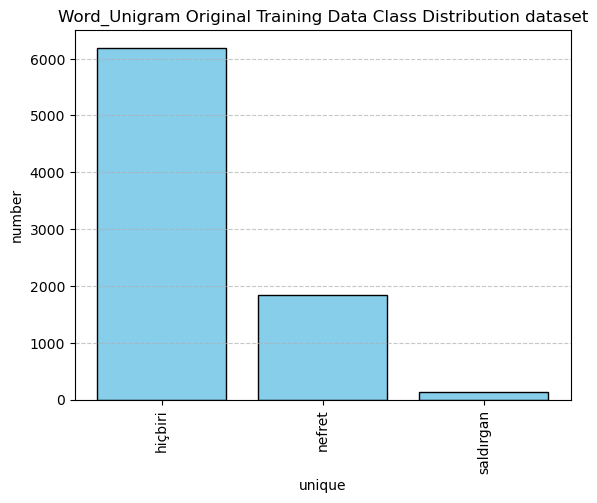

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


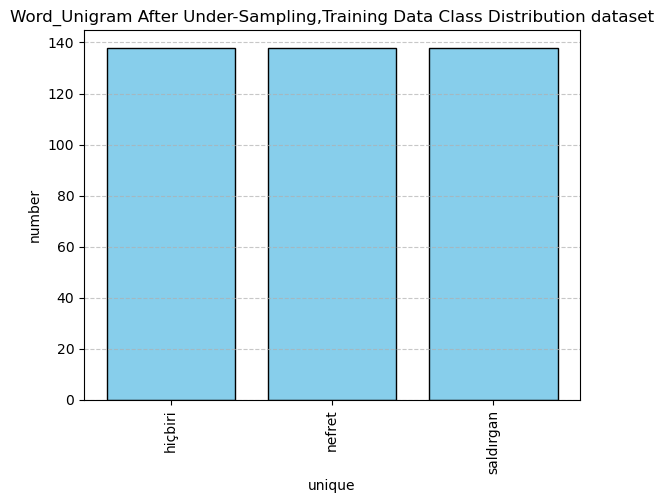

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


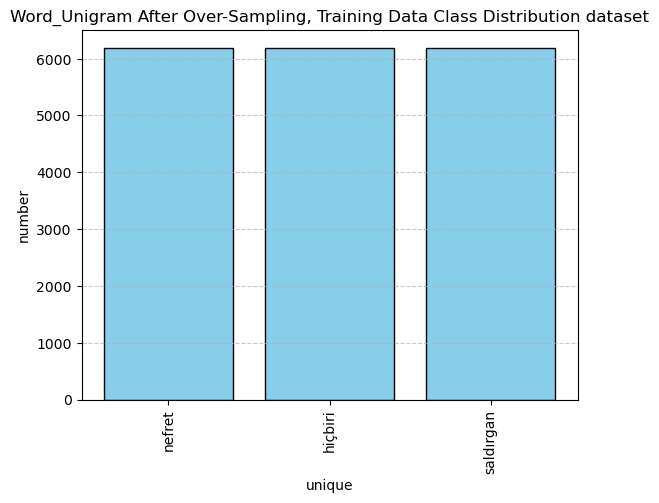

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


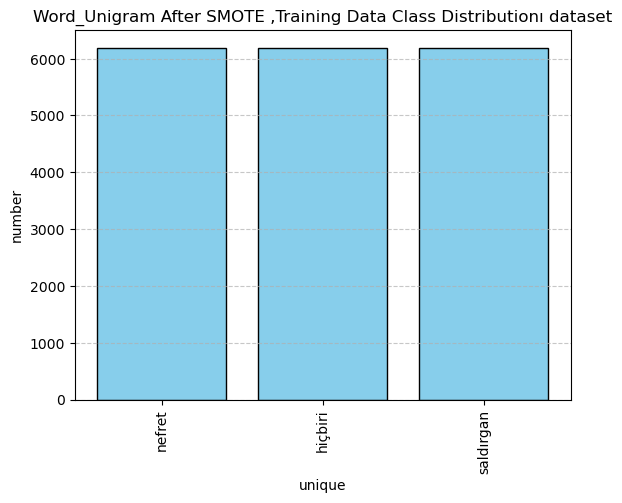


Word_Unigram:

XGBoost,Under-Sampling,Word_Unigram:
accuracy: 0.5095354523227383
precision: 0.6575901117758006
recall: 0.5095354523227383
f1: 0.5646169098292118
Training Accuracy: 0.3695652173913044
Validation Accuracy: 0.5095354523227383

Word_Unigram:

CatBoostC,Under-Sampling,Word_Unigram:
accuracy: 0.6440097799511002
precision: 0.7080178858853468
recall: 0.6440097799511002
f1: 0.6674804861339697
Training Accuracy: 0.47826086956521735
Validation Accuracy: 0.6440097799511002

Word_Unigram:

MLPC-sgd,Under-Sampling,Word_Unigram:
accuracy: 0.7466992665036675
precision: 0.557559794597115
recall: 0.7466992665036675
f1: 0.6384153303197649
Training Accuracy: 0.3333333333333333
Validation Accuracy: 0.7466992665036675

Word_Unigram:

ExtraTreesClassifier,Under-Sampling,Word_Unigram:
accuracy: 0.6332518337408313
precision: 0.7261700861211683
recall: 0.6332518337408313
f1: 0.6652686178056041
Training Accuracy: 0.47826086956521735
Validation Accuracy: 0.6332518337408313

Word_Unigram:

XGBoost

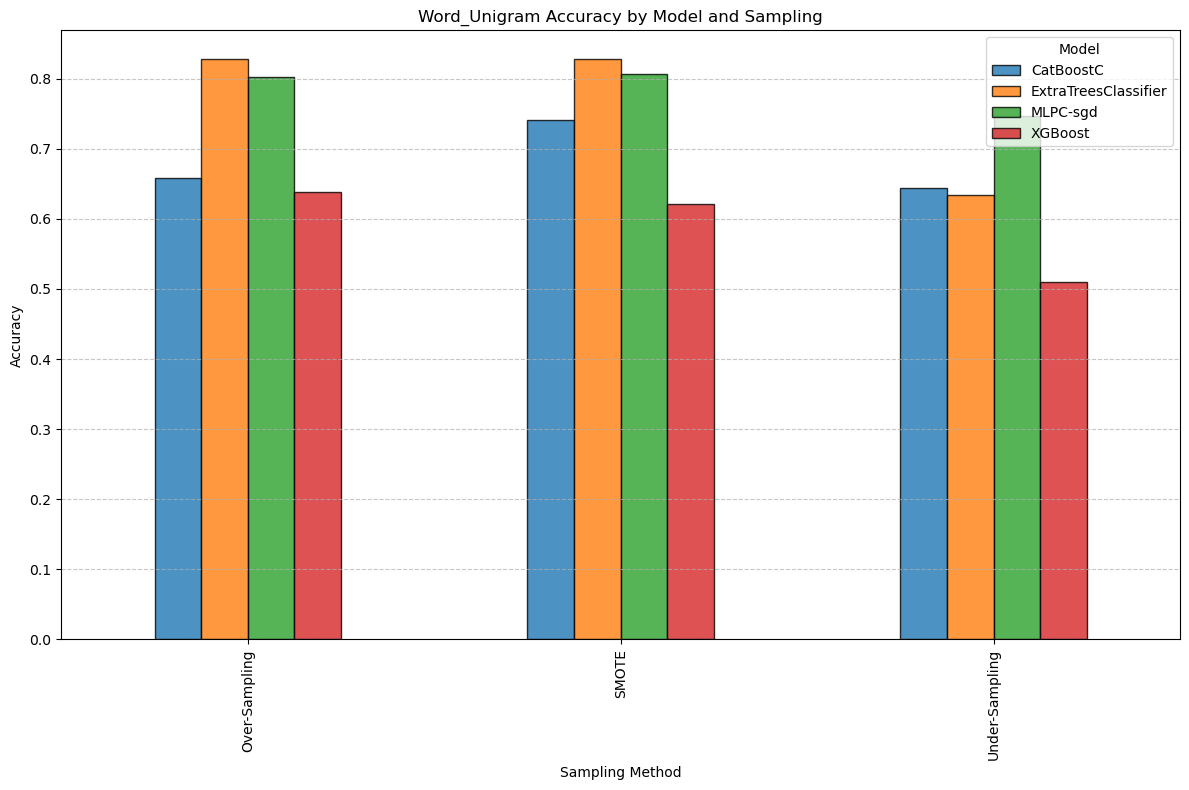

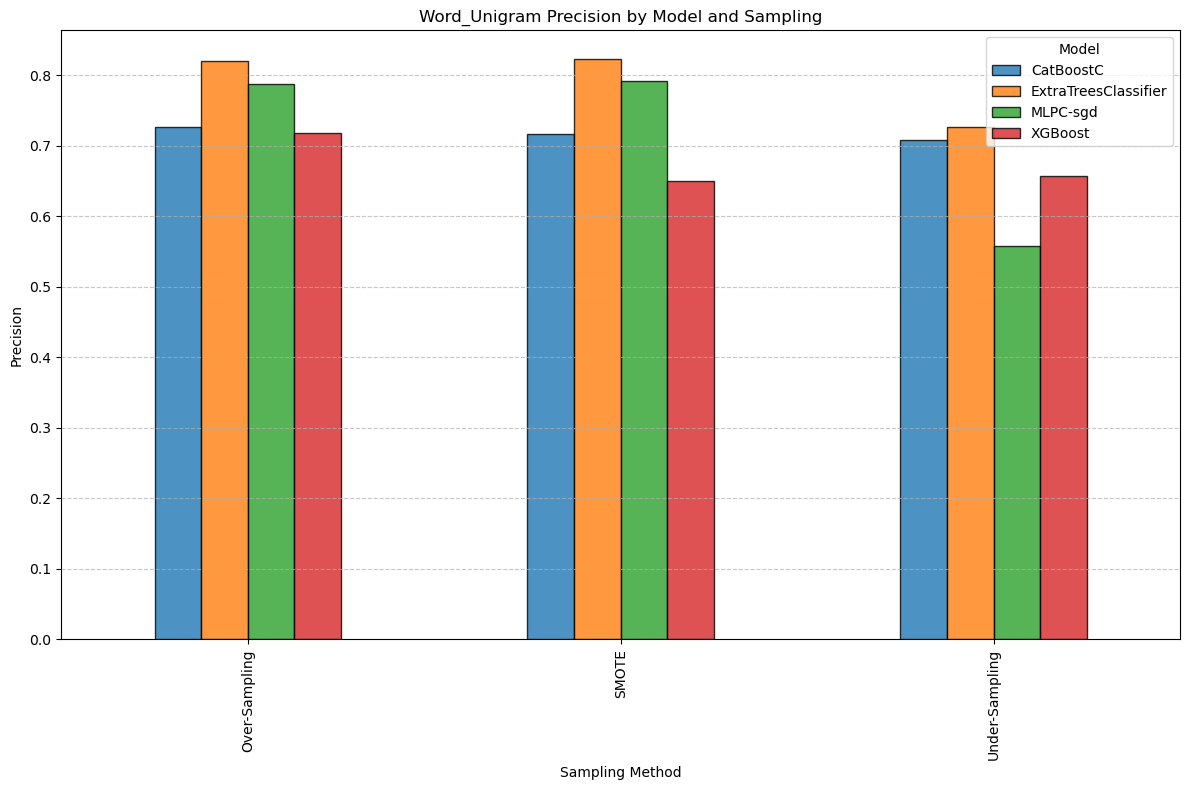

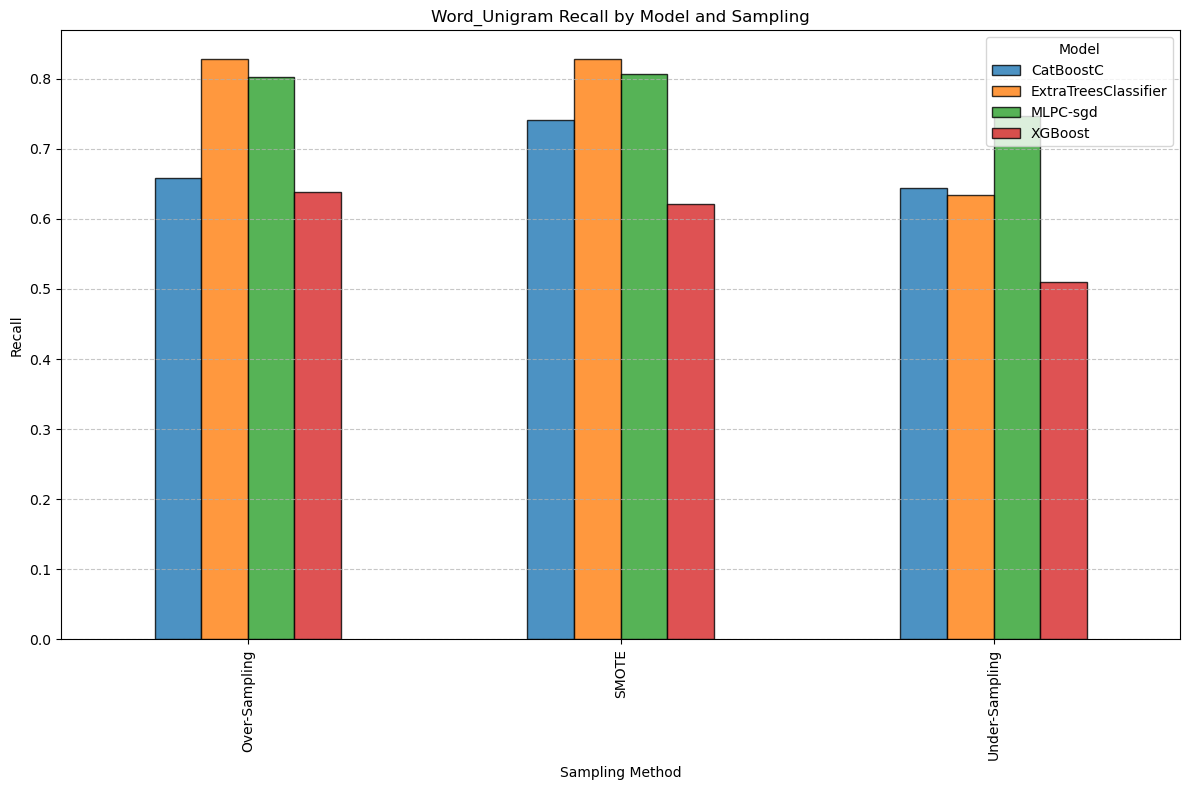

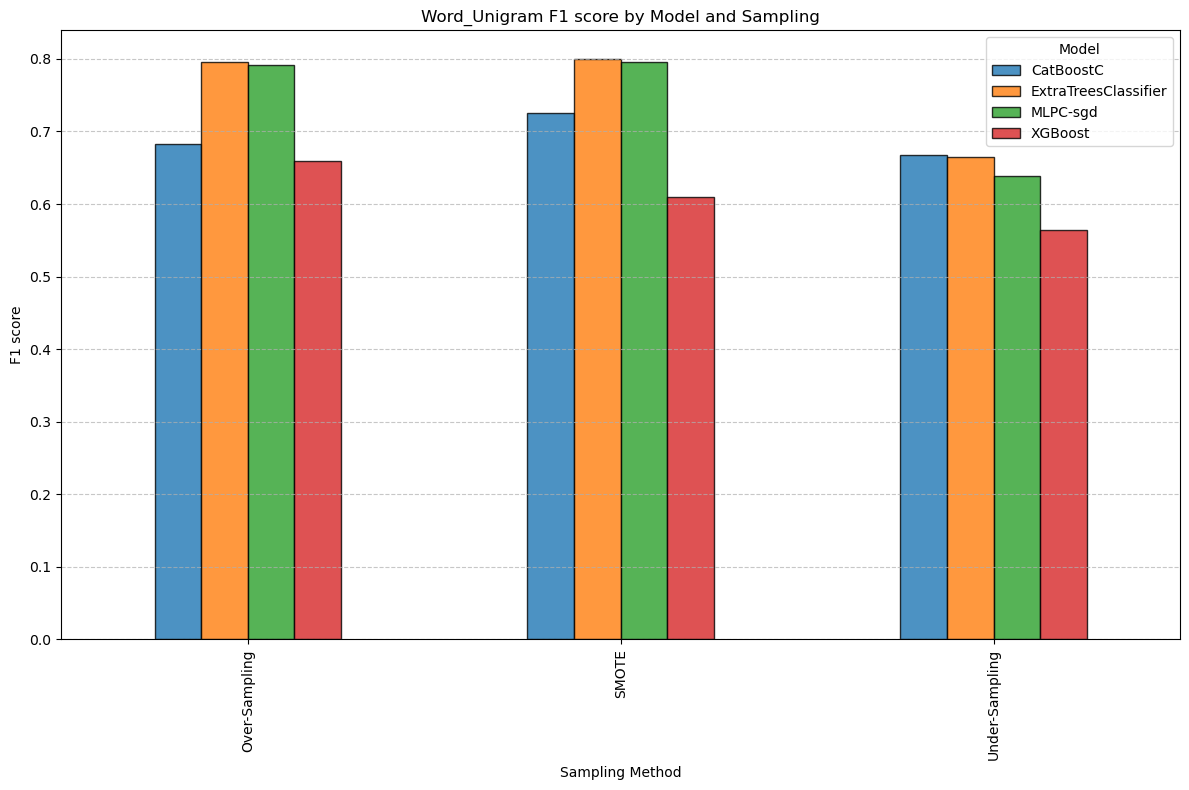

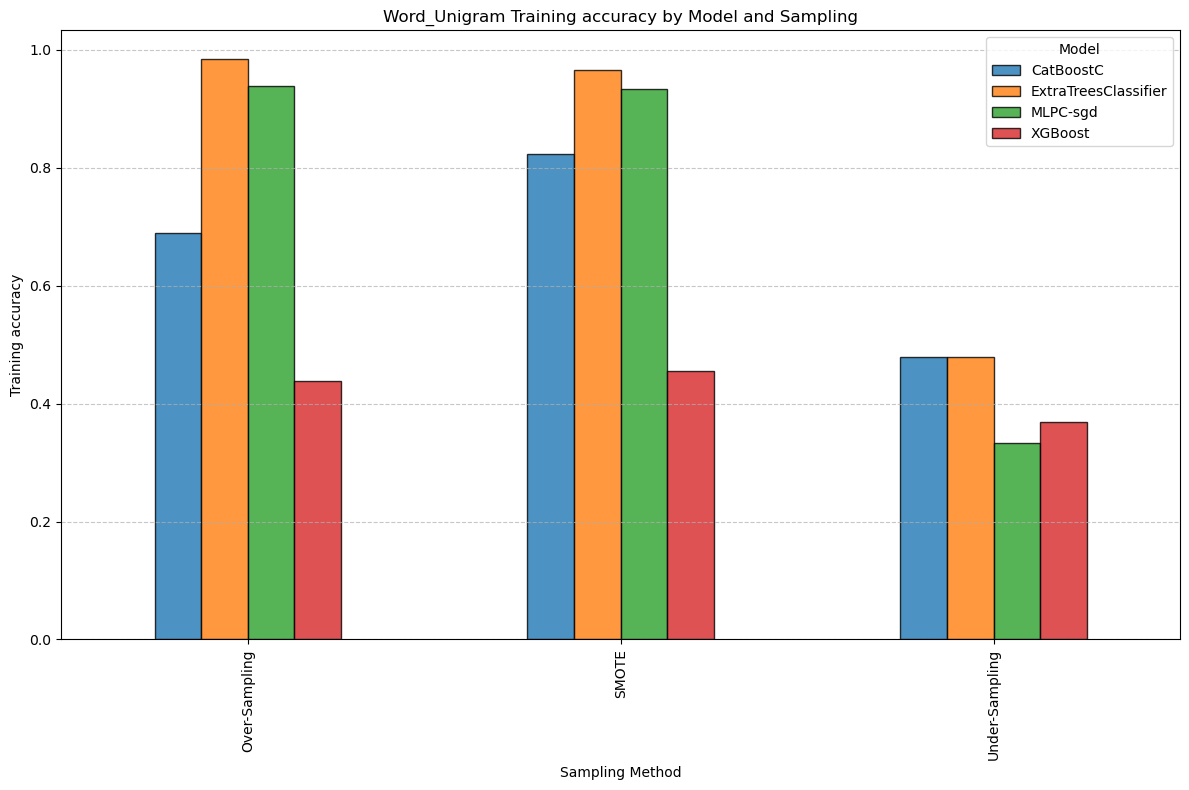

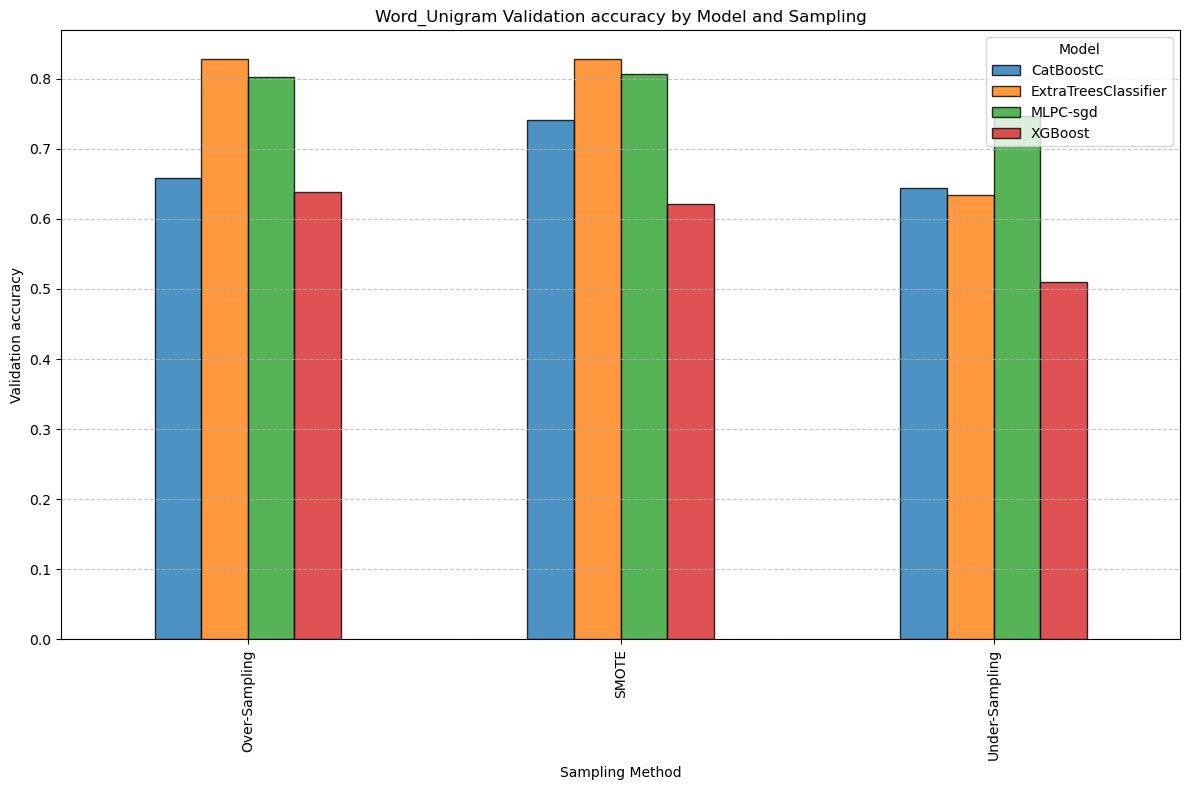

In [109]:
results_df = feature_unionAndmodel_training("Word_Unigram",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["Word_Unigram"] = results_df

# Word bigram-------------------------------------------

In [111]:

feature_union = FeatureUnion([
    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf)
])



etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


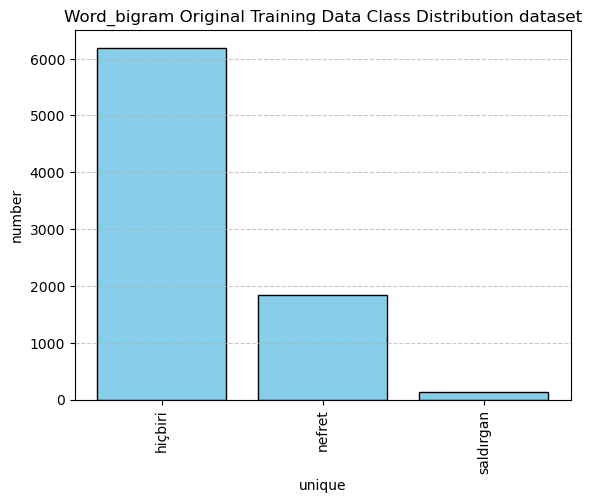

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


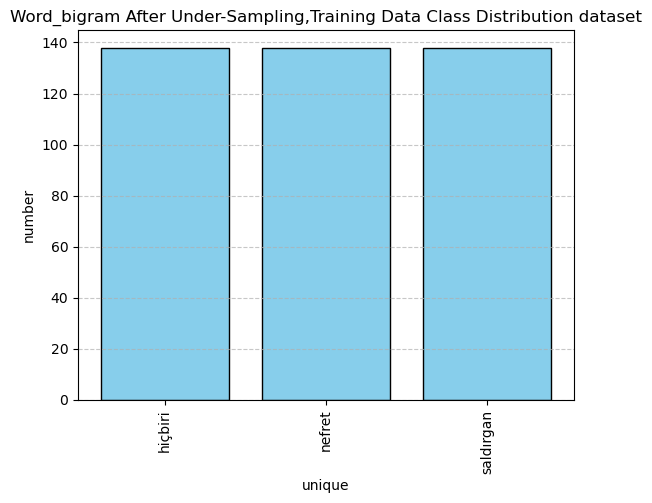

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


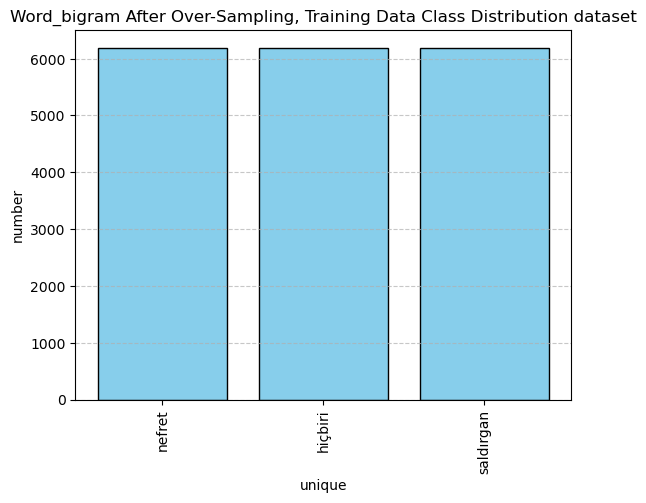

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


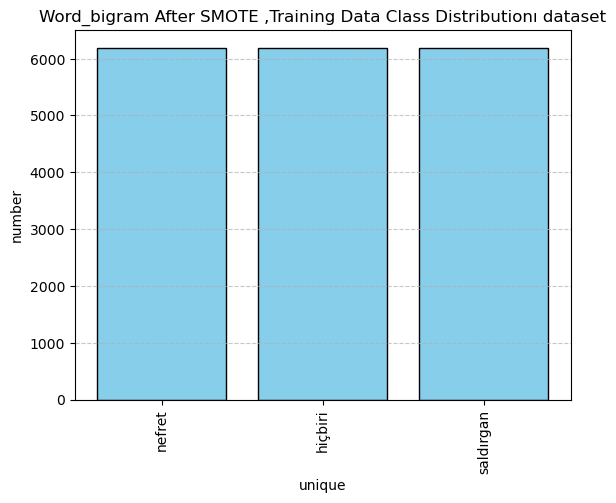


Word_bigram:

XGBoost,Under-Sampling,Word_bigram:
accuracy: 0.7447432762836186
precision: 0.5574622465122969
recall: 0.7447432762836186
f1: 0.6376355384833673
Training Accuracy: 0.36231884057971014
Validation Accuracy: 0.7447432762836186

Word_bigram:

CatBoostC,Under-Sampling,Word_bigram:
accuracy: 0.7383863080684596
precision: 0.7182721795030548
recall: 0.7383863080684596
f1: 0.6391073421502371
Training Accuracy: 0.35748792270531404
Validation Accuracy: 0.7383863080684596

Word_bigram:

MLPC-sgd,Under-Sampling,Word_bigram:
accuracy: 0.013691931540342298
precision: 0.0001874689893054202
recall: 0.013691931540342298
f1: 0.0003698736933232844
Training Accuracy: 0.3333333333333333
Validation Accuracy: 0.013691931540342298

Word_bigram:

ExtraTreesClassifier,Under-Sampling,Word_bigram:
accuracy: 0.3095354523227384
precision: 0.6727032185641018
recall: 0.3095354523227384
f1: 0.2534120249048235
Training Accuracy: 0.3913043478260869
Validation Accuracy: 0.3095354523227384

Word_bigram:

XGB

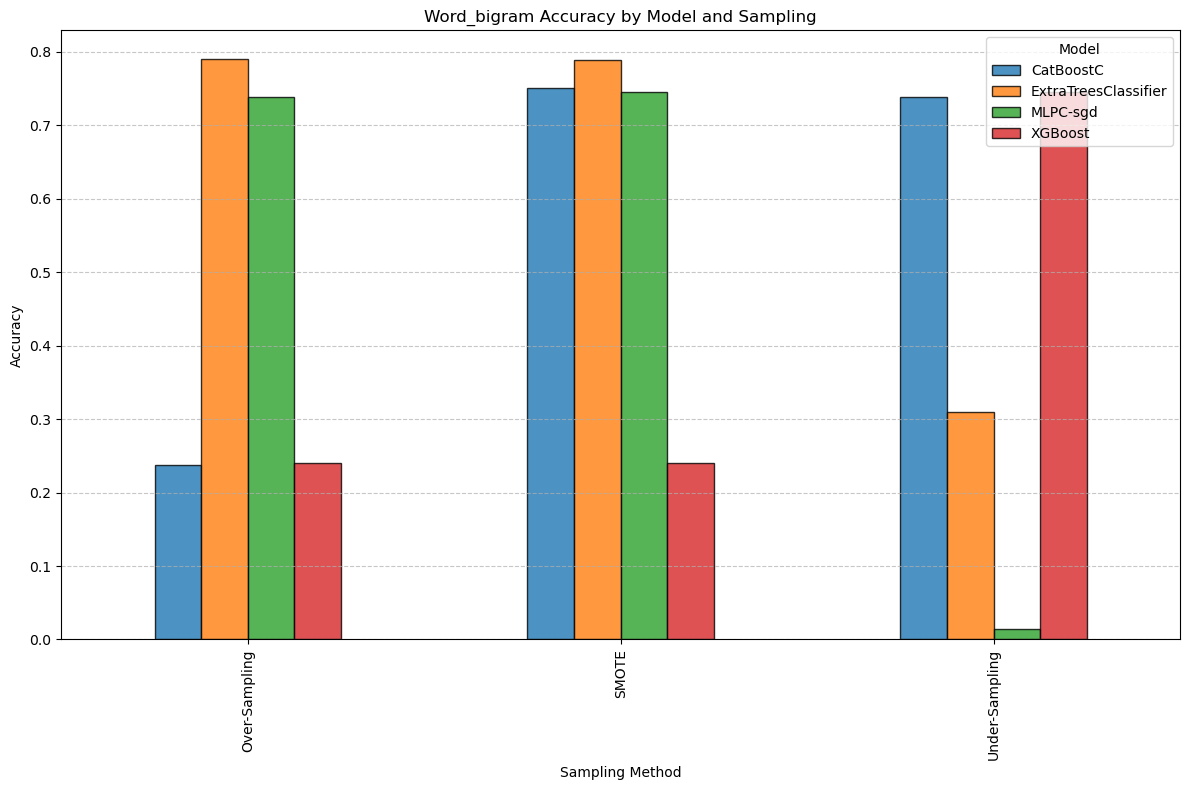

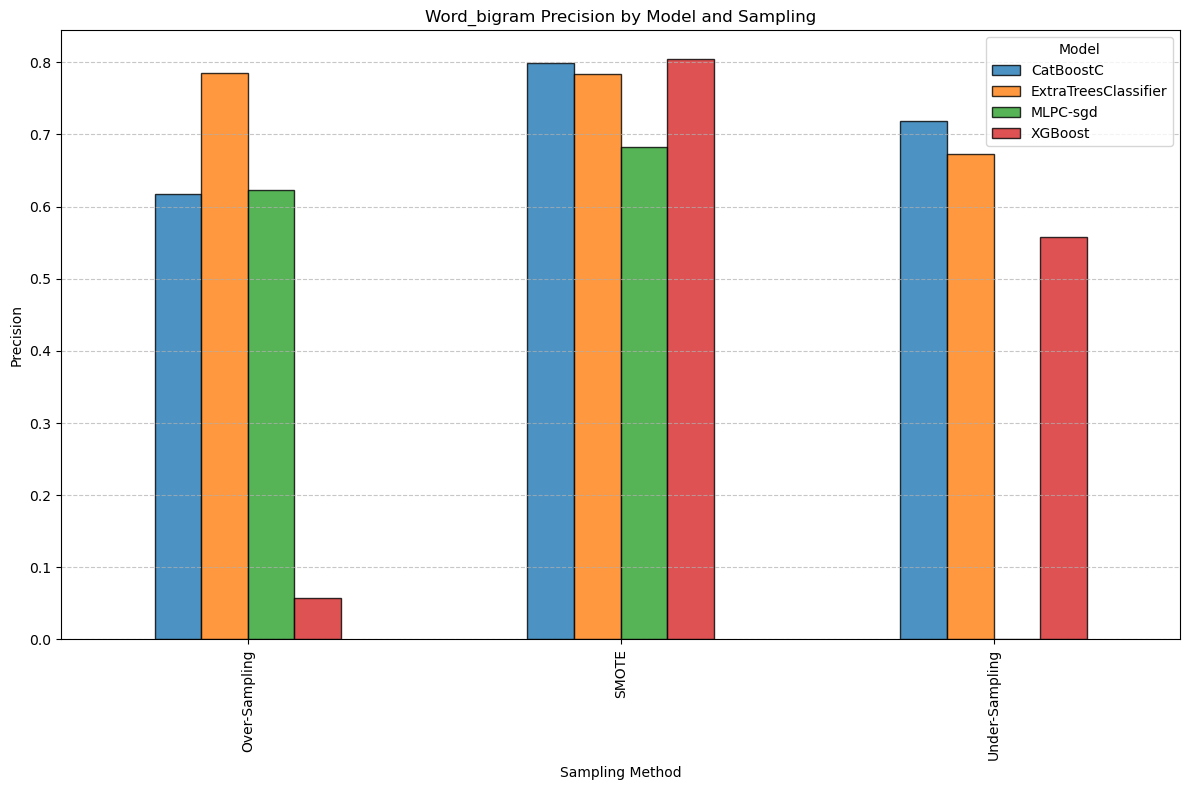

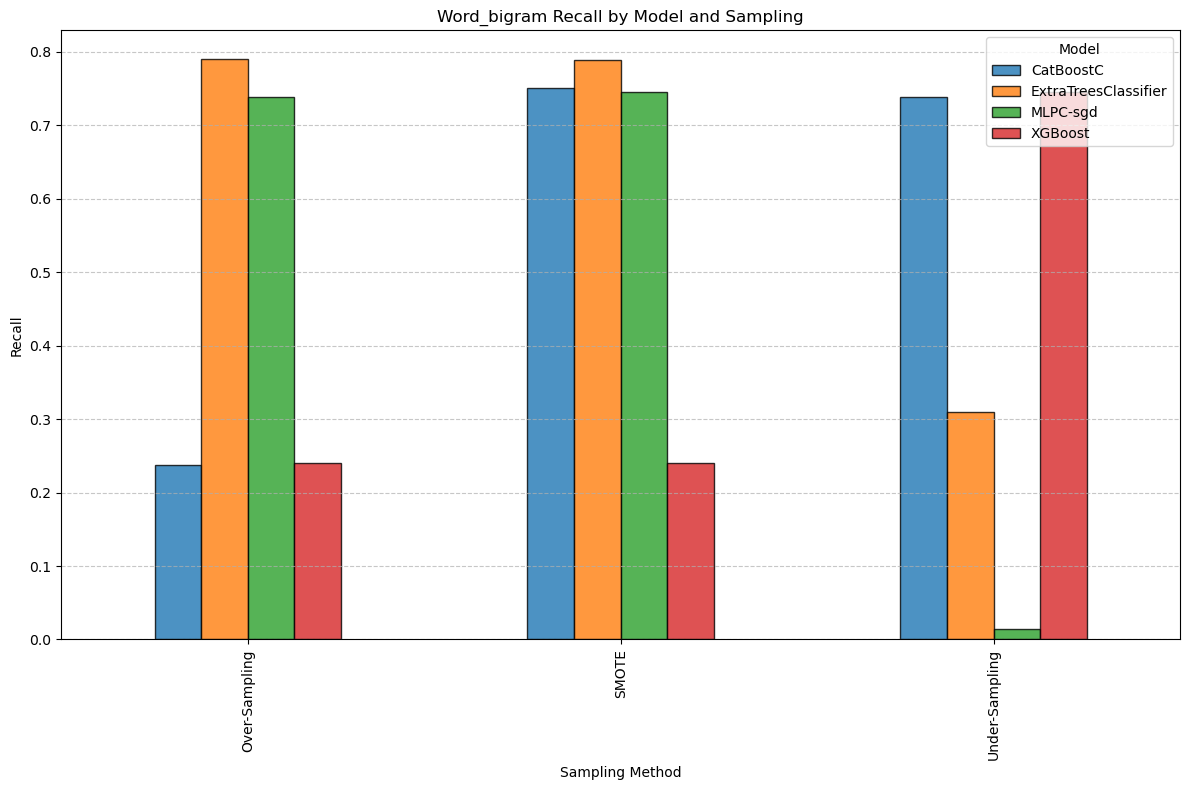

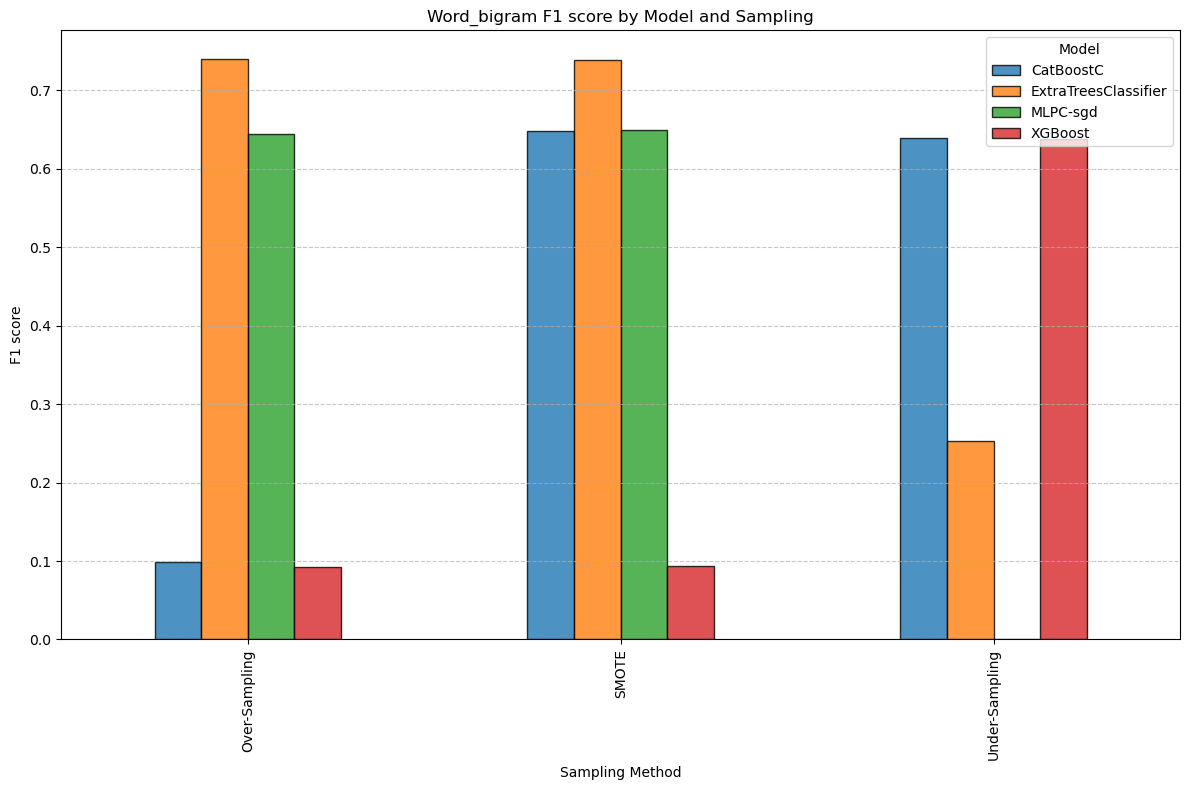

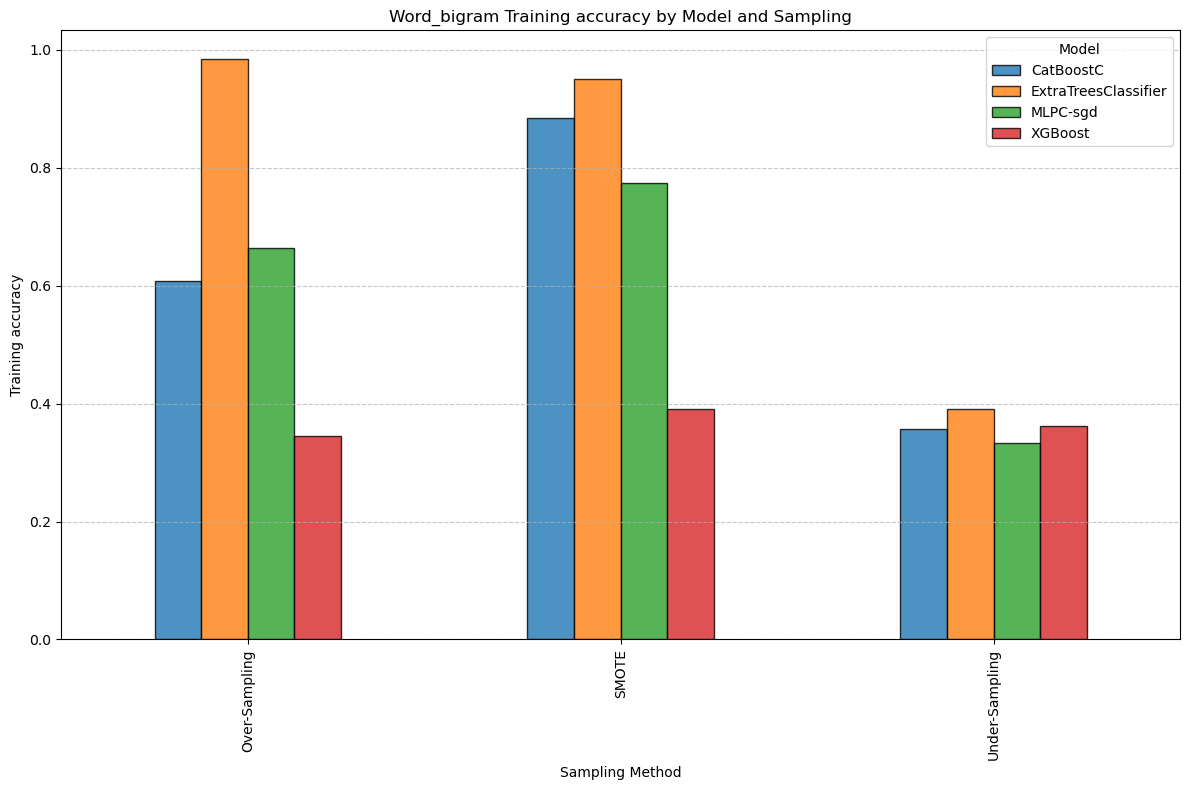

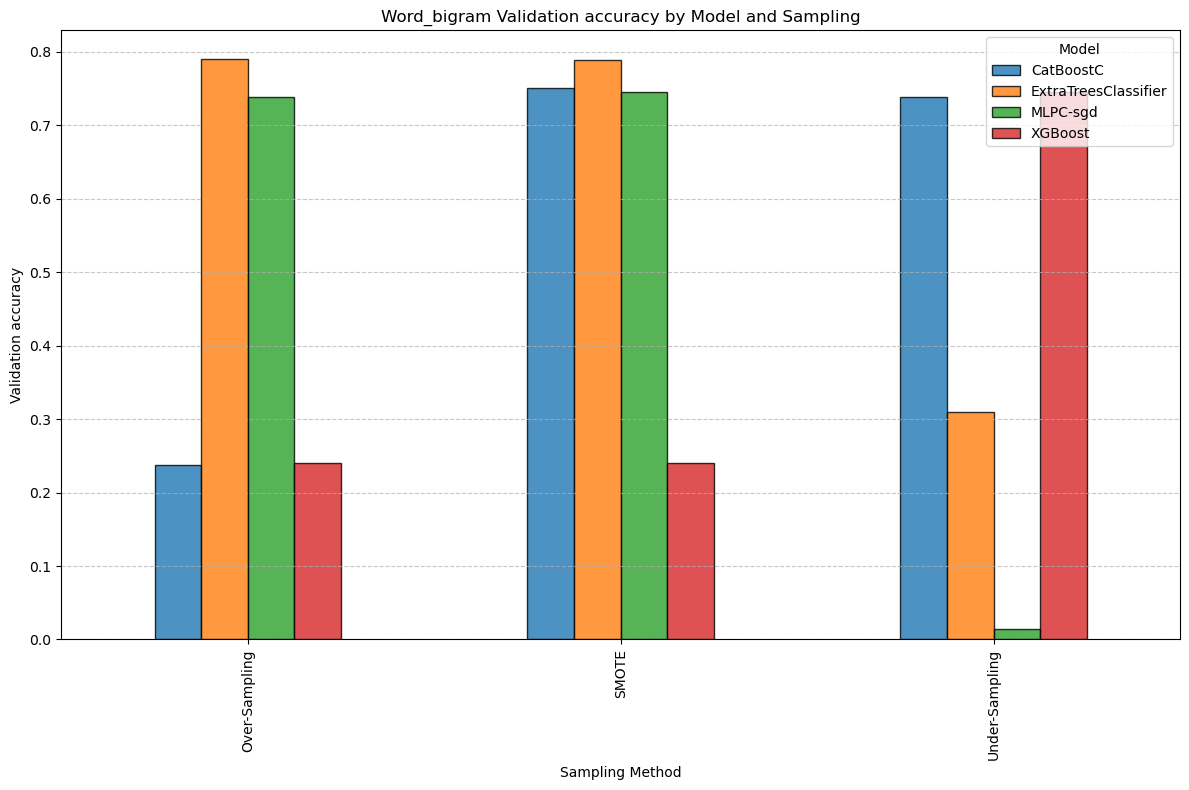

In [112]:
feature_unionAndmodel_training("Word_bigram",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["Word_bigram"] = results_df


# char bigram-------------------------------------------

In [114]:

feature_union = FeatureUnion([
    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf)
])


etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


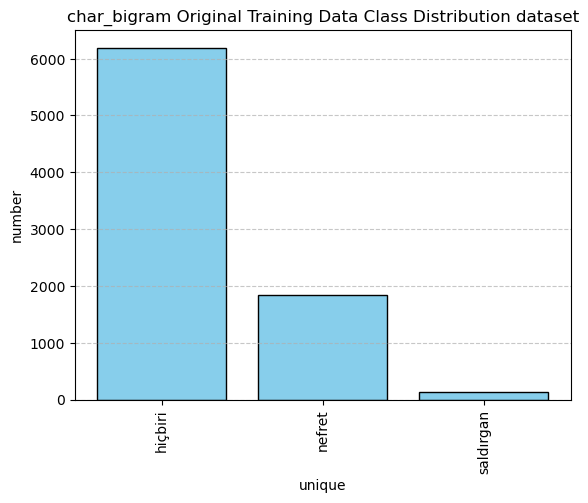

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


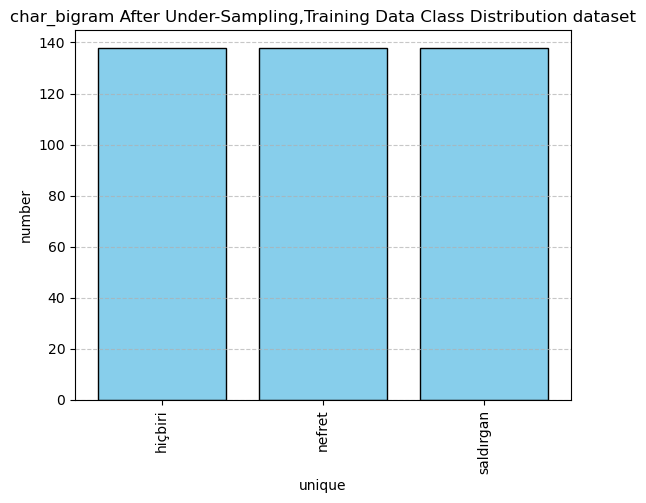

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


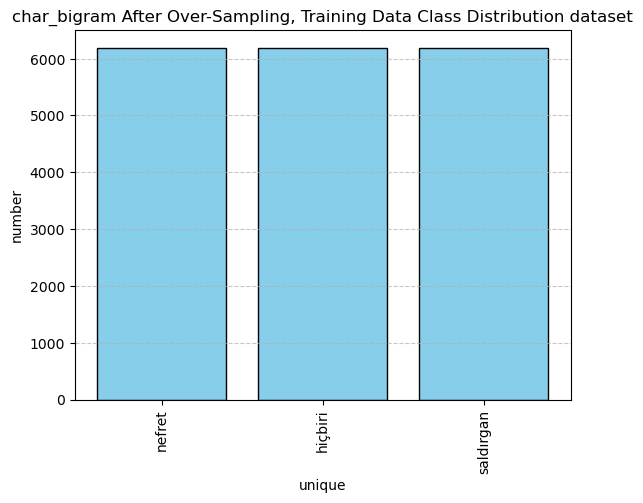

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


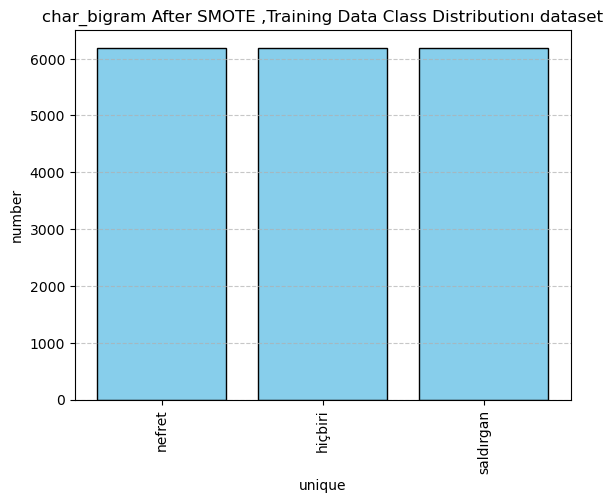


char_bigram:

XGBoost,Under-Sampling,char_bigram:
accuracy: 0.6264058679706601
precision: 0.6347017545271905
recall: 0.6264058679706601
f1: 0.6303623506936571
Training Accuracy: 0.3333333333333333
Validation Accuracy: 0.6264058679706601

char_bigram:

CatBoostC,Under-Sampling,char_bigram:
accuracy: 0.5119804400977995
precision: 0.7012931523157435
recall: 0.5119804400977995
f1: 0.5733309891699646
Training Accuracy: 0.45893719806763283
Validation Accuracy: 0.5119804400977995

char_bigram:

MLPC-sgd,Under-Sampling,char_bigram:
accuracy: 0.20244498777506112
precision: 0.6621240364270823
recall: 0.20244498777506112
f1: 0.24674215185157422
Training Accuracy: 0.38647342995169076
Validation Accuracy: 0.20244498777506112

char_bigram:

ExtraTreesClassifier,Under-Sampling,char_bigram:
accuracy: 0.49339853300733494
precision: 0.7144449205645036
recall: 0.49339853300733494
f1: 0.5577858356038657
Training Accuracy: 0.5144927536231885
Validation Accuracy: 0.49339853300733494

char_bigram:

XGBoost,

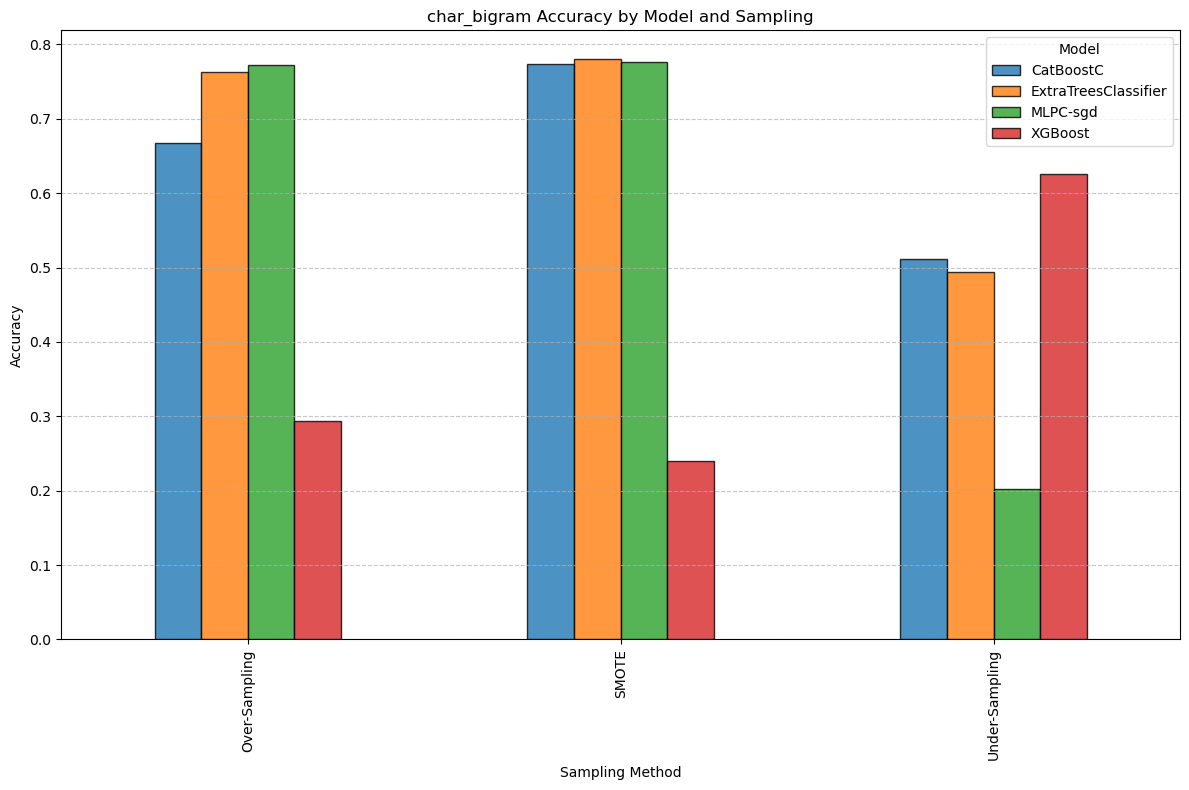

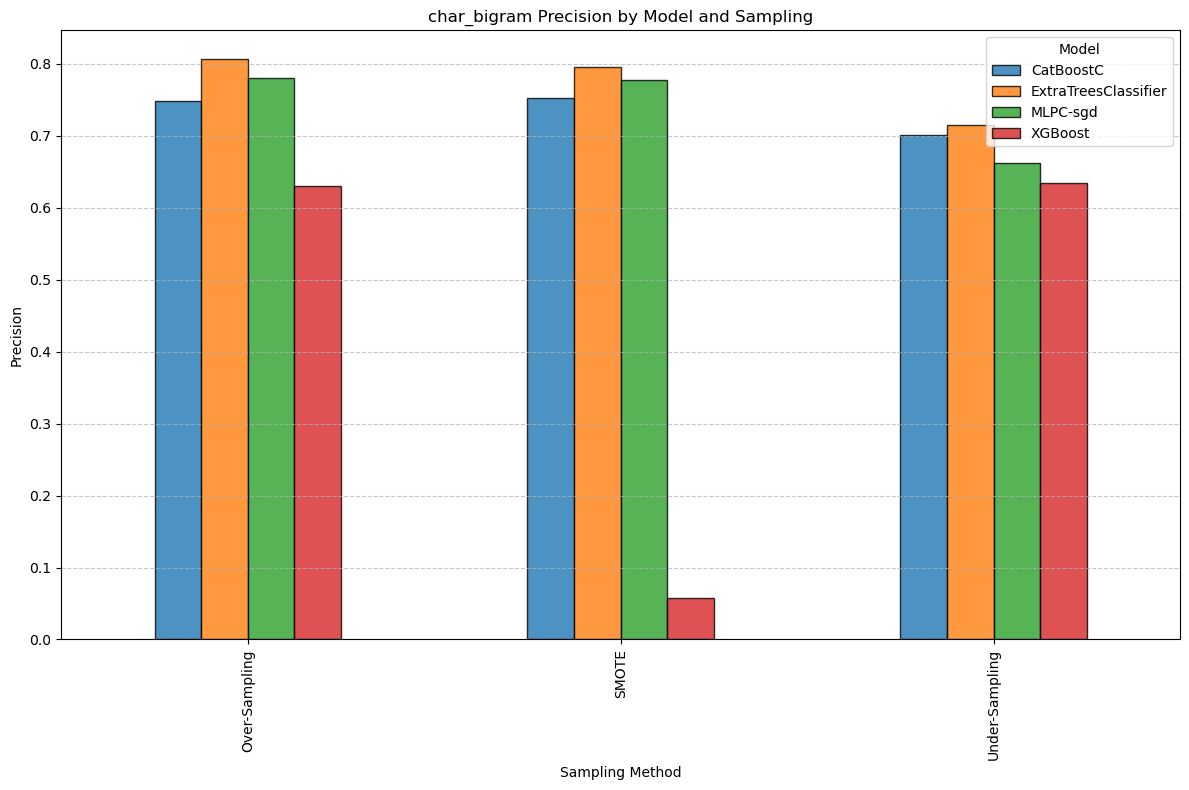

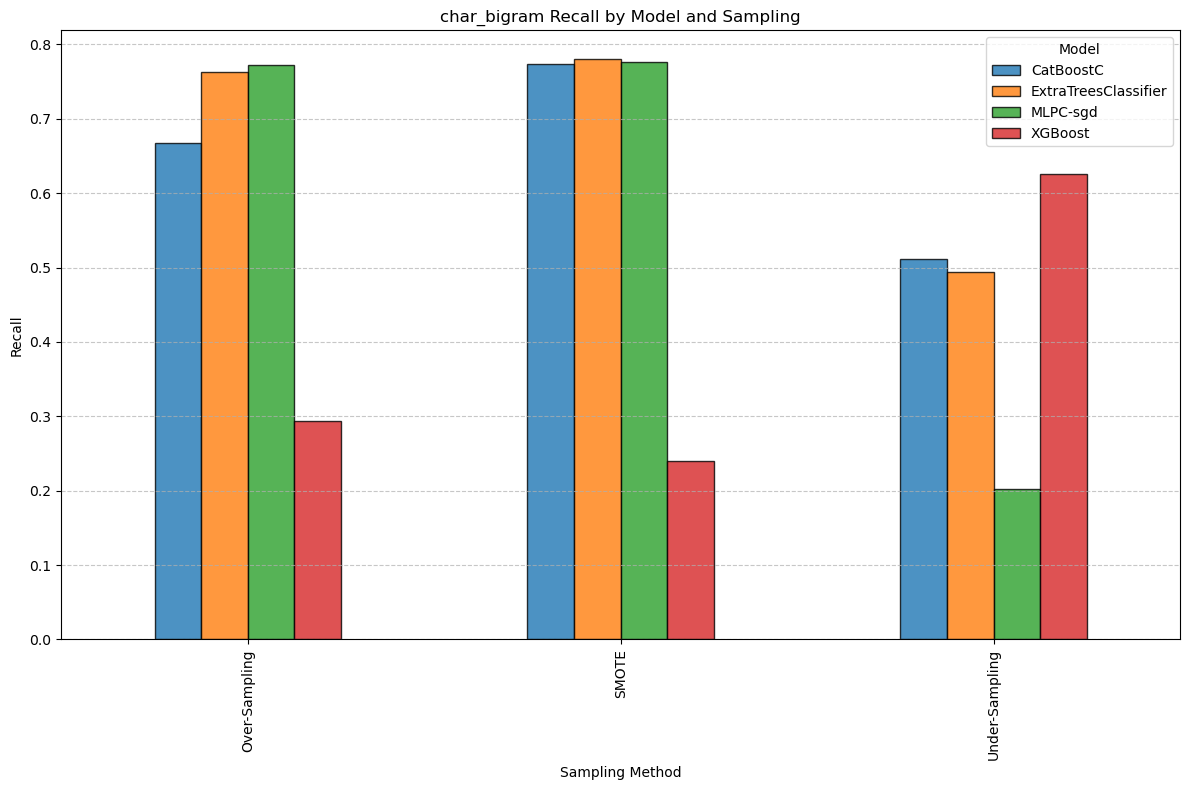

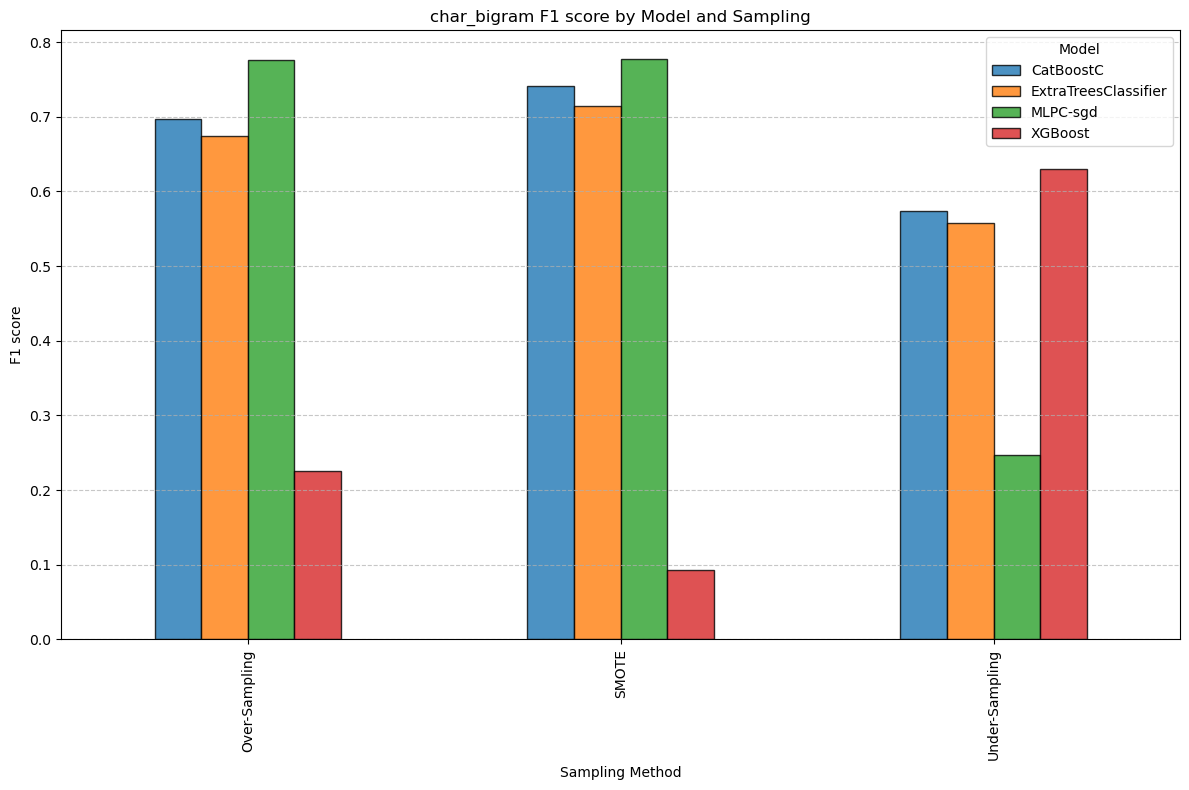

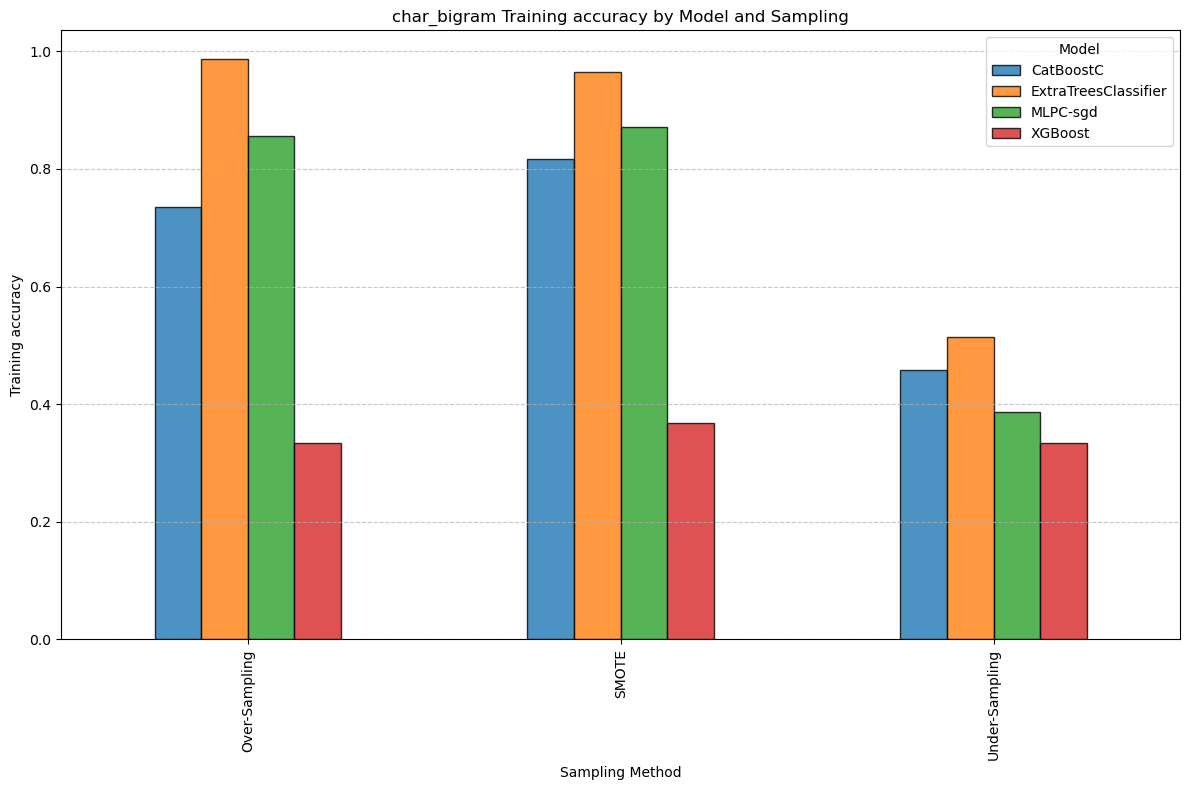

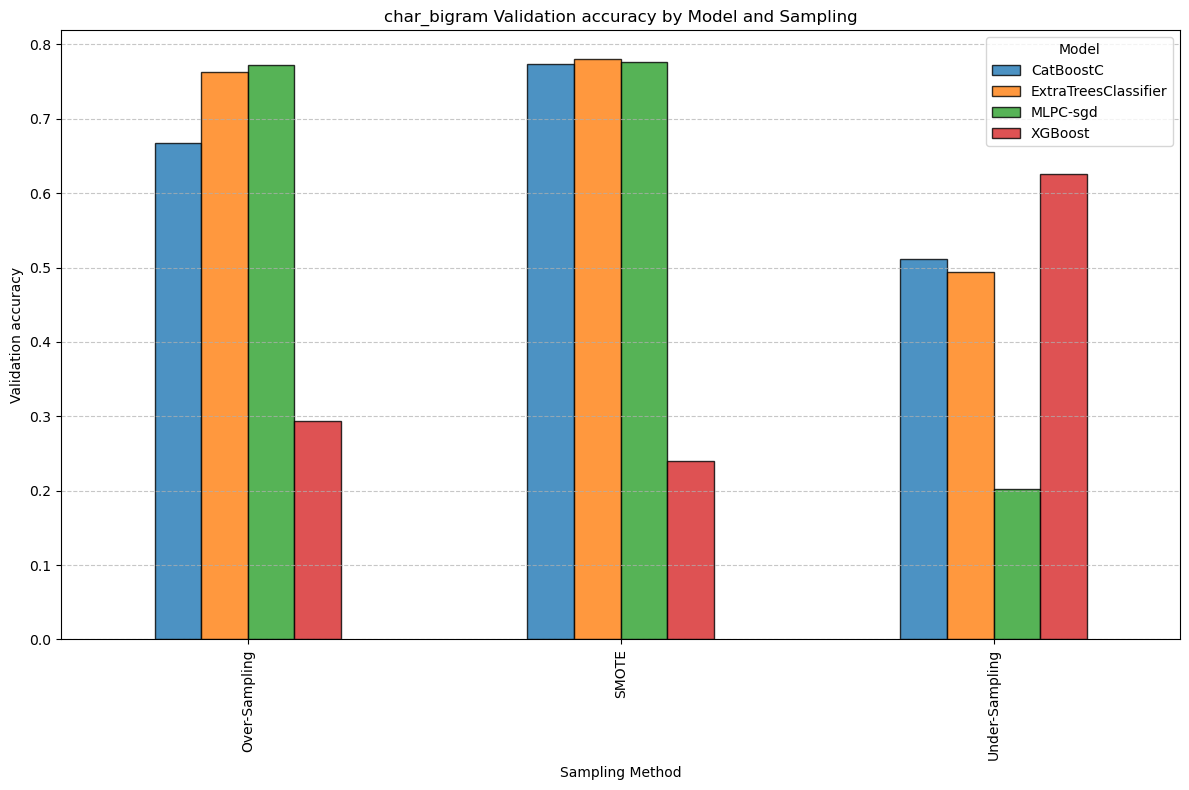

In [115]:
feature_unionAndmodel_training("char_bigram",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["char_bigram"] = results_df

# char trigram-------------------------------------------

In [117]:

feature_union = FeatureUnion([
    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
])


etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


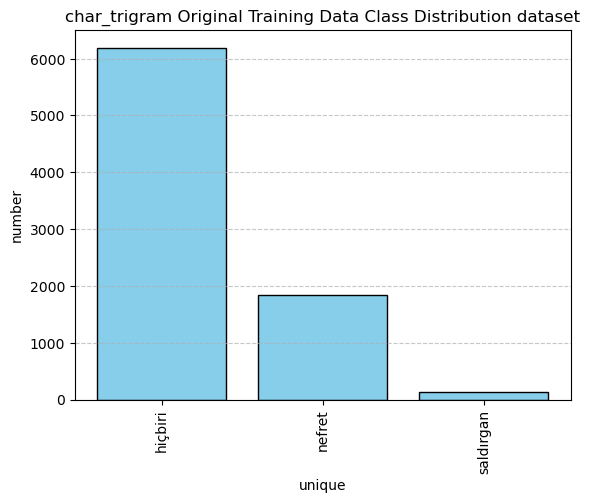

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


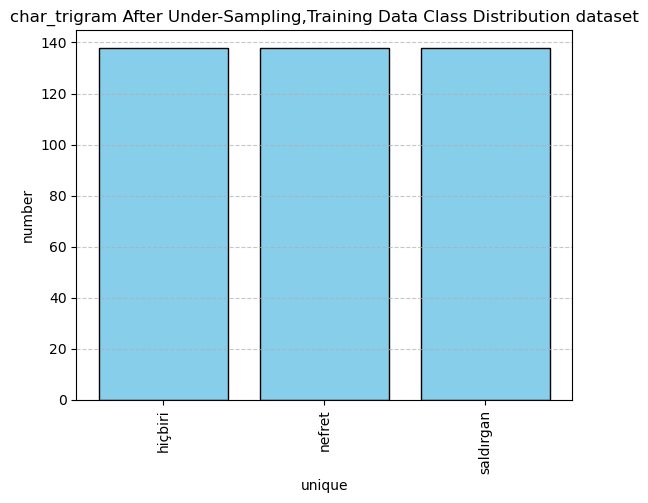

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


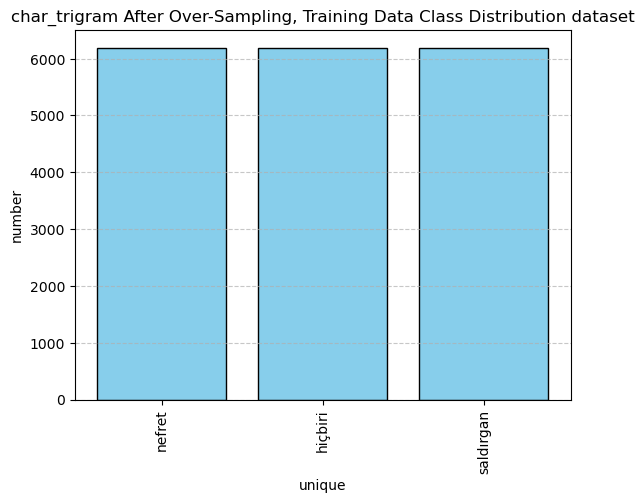

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


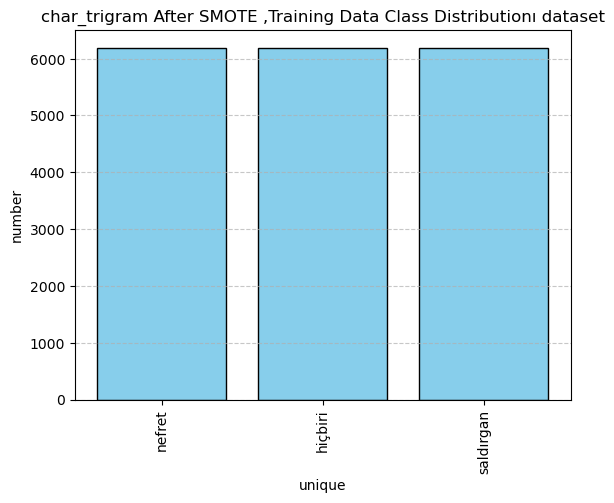


char_trigram:

XGBoost,Under-Sampling,char_trigram:
accuracy: 0.7437652811735941
precision: 0.5575501150476575
recall: 0.7437652811735941
f1: 0.637334222419797
Training Accuracy: 0.3357487922705314
Validation Accuracy: 0.7437652811735941

char_trigram:

CatBoostC,Under-Sampling,char_trigram:
accuracy: 0.5266503667481662
precision: 0.6784295980459428
recall: 0.5266503667481662
f1: 0.5809084261817494
Training Accuracy: 0.4855072463768116
Validation Accuracy: 0.5266503667481662

char_trigram:

MLPC-sgd,Under-Sampling,char_trigram:
accuracy: 0.5114914425427873
precision: 0.6981192263978314
recall: 0.5114914425427873
f1: 0.56881666496536
Training Accuracy: 0.4106280193236715
Validation Accuracy: 0.5114914425427873

char_trigram:

ExtraTreesClassifier,Under-Sampling,char_trigram:
accuracy: 0.556479217603912
precision: 0.740135399322862
recall: 0.556479217603912
f1: 0.6139464031302234
Training Accuracy: 0.533816425120773
Validation Accuracy: 0.556479217603912

char_trigram:

XGBoost,Over-Sam

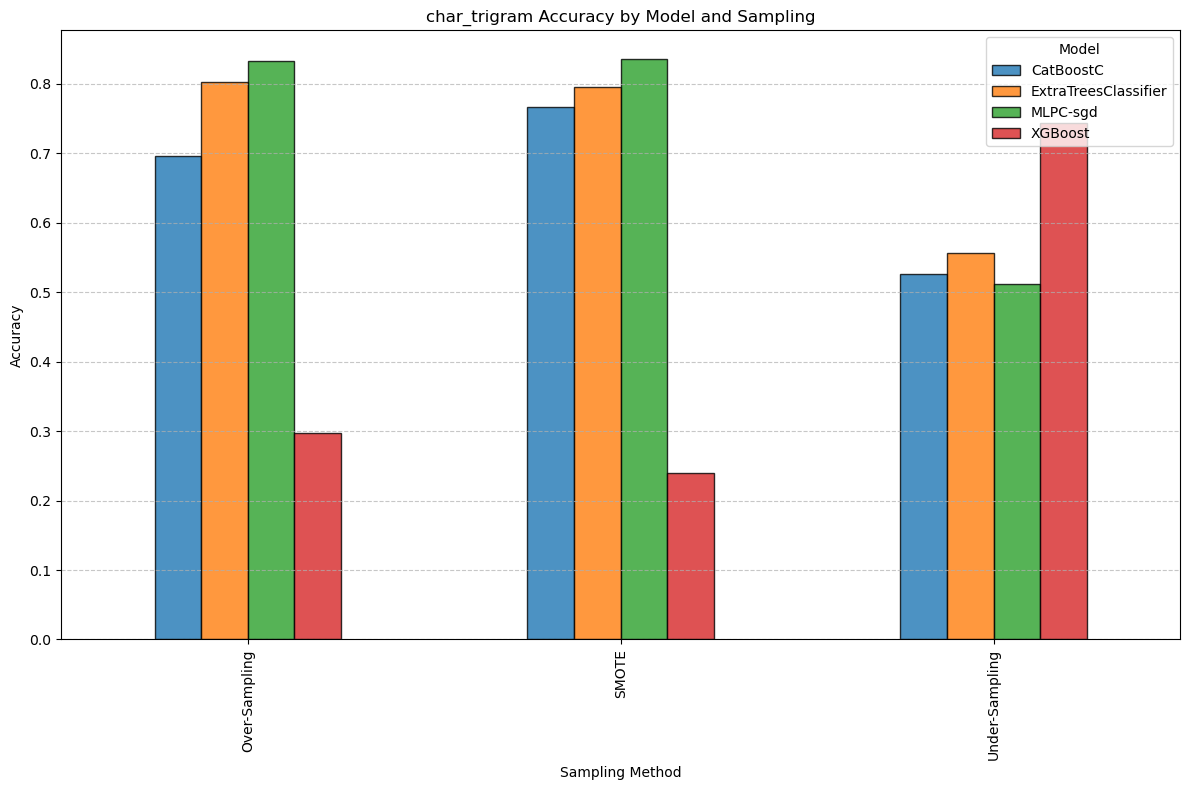

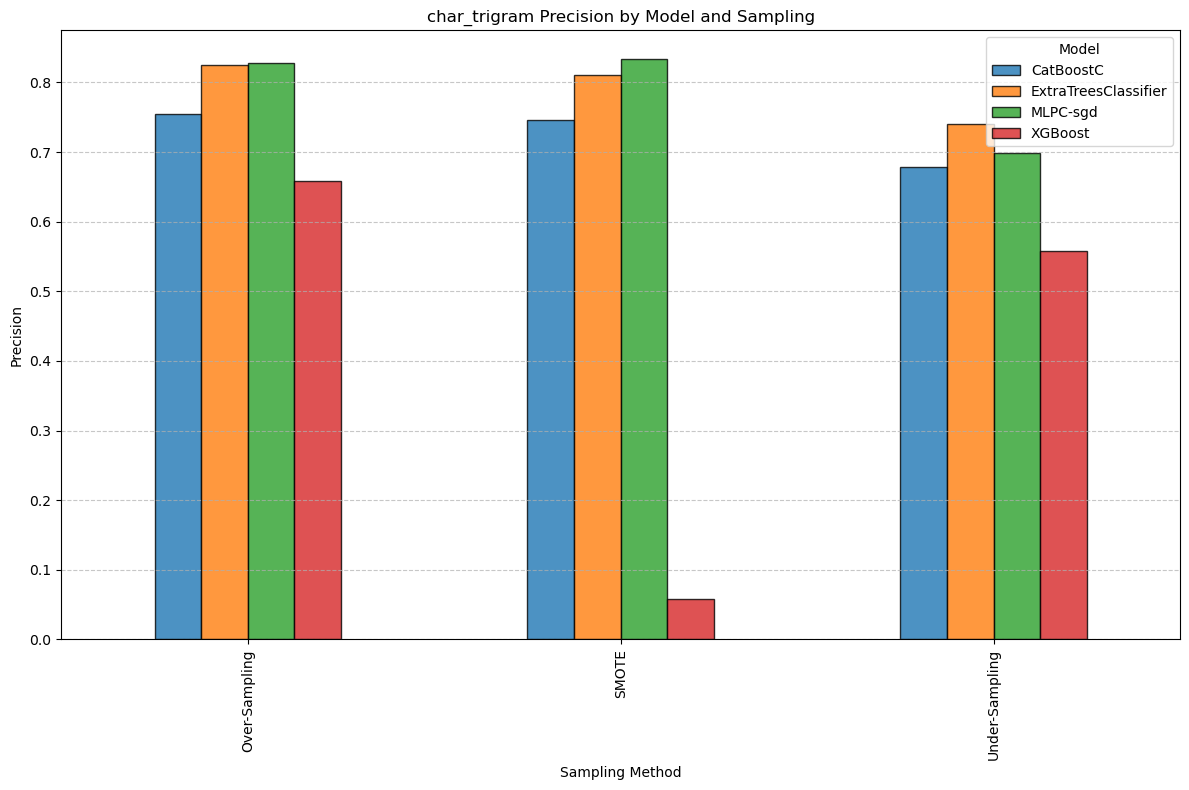

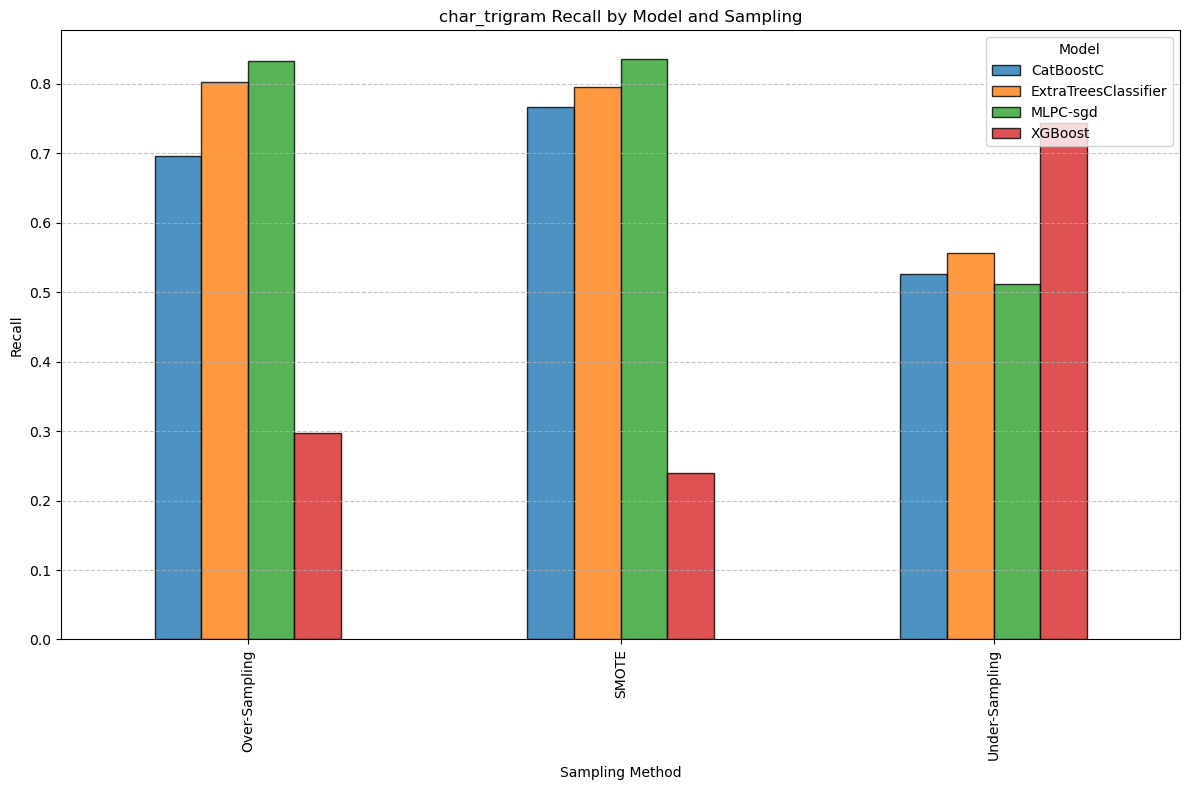

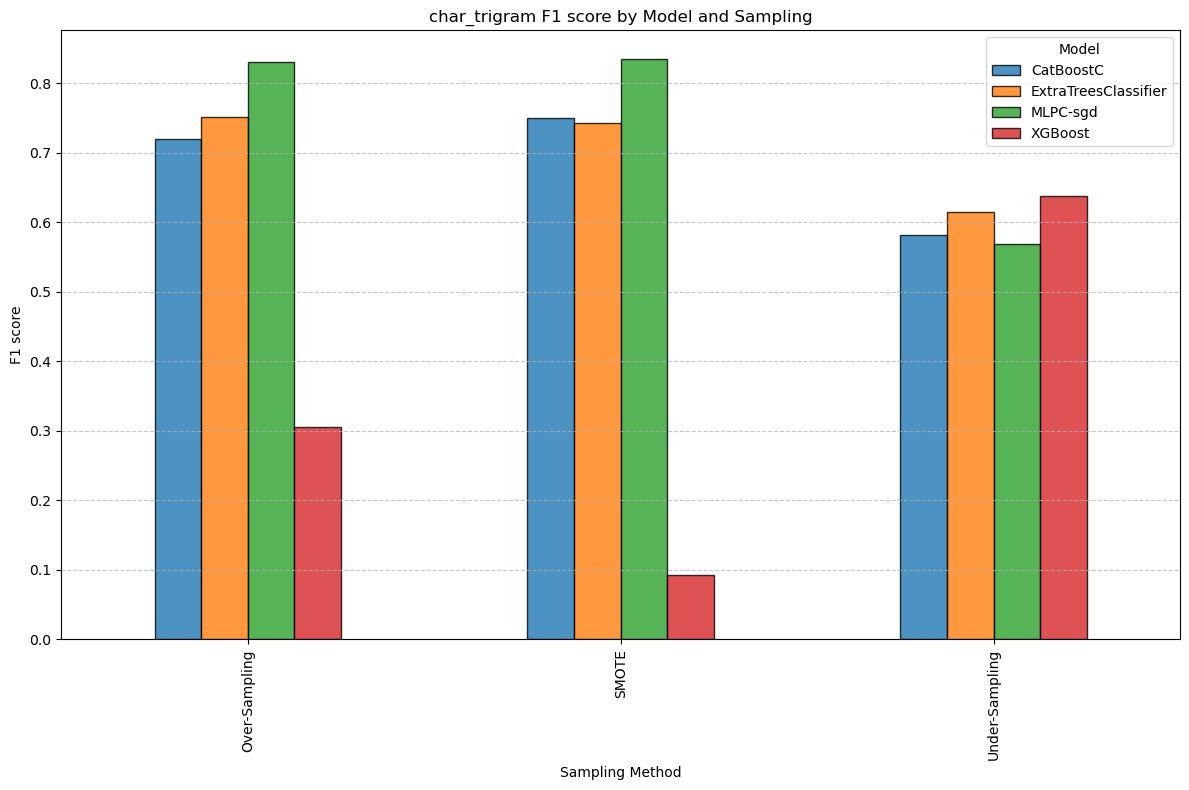

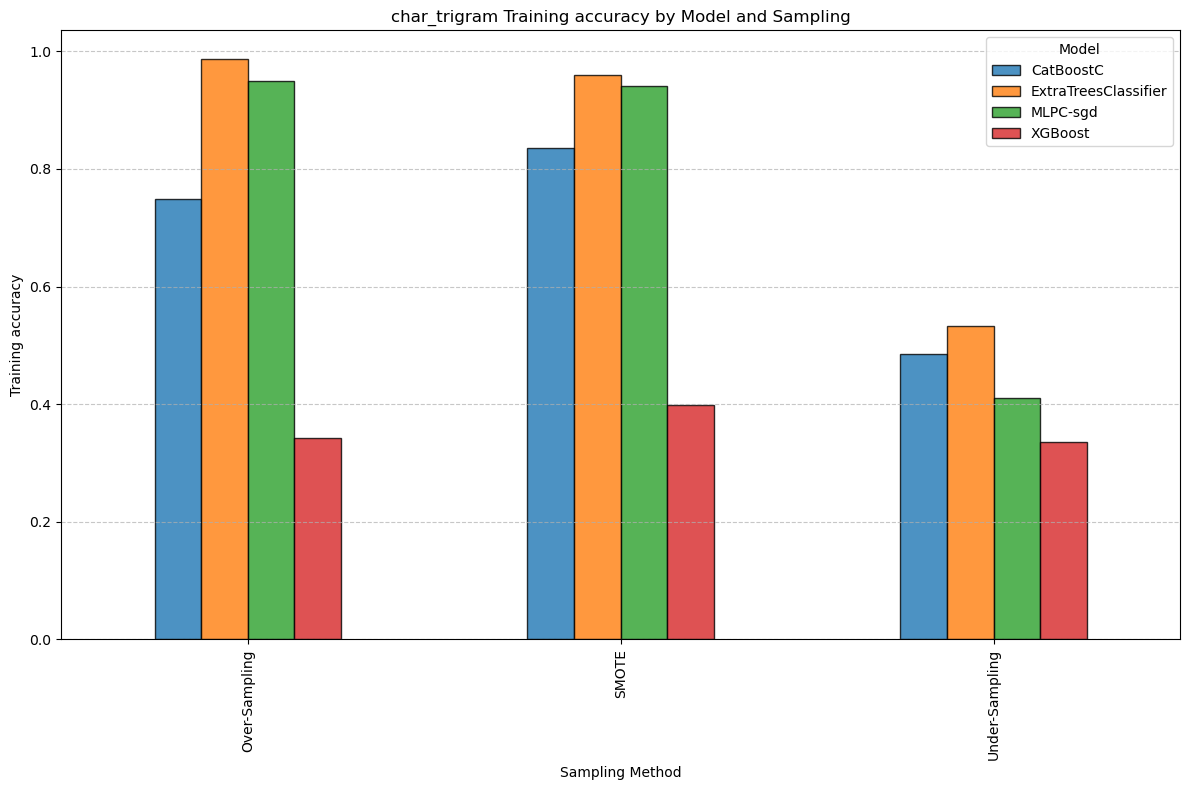

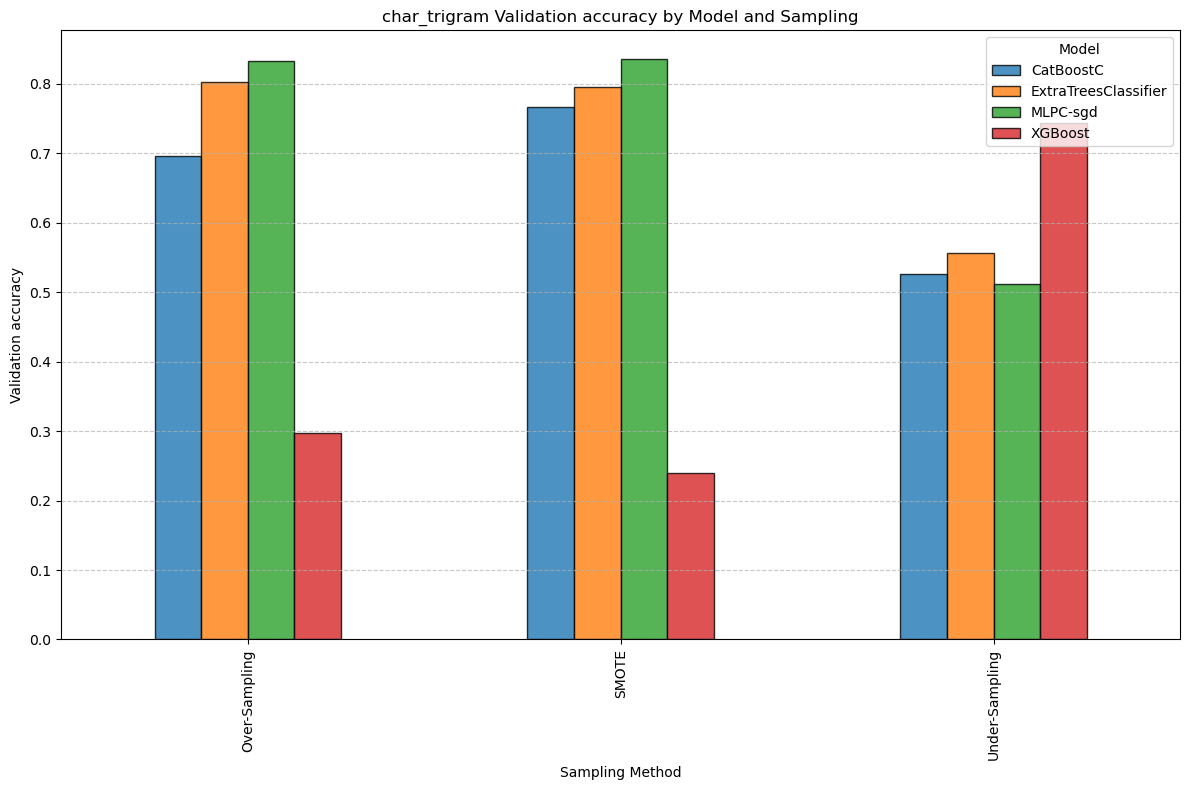

In [118]:
feature_unionAndmodel_training("char_trigram",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["char_trigram"] = results_df



# char bigram + char trigram-------------------------------------------

In [120]:

feature_union = FeatureUnion([
    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf),
    
    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
    
])


etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


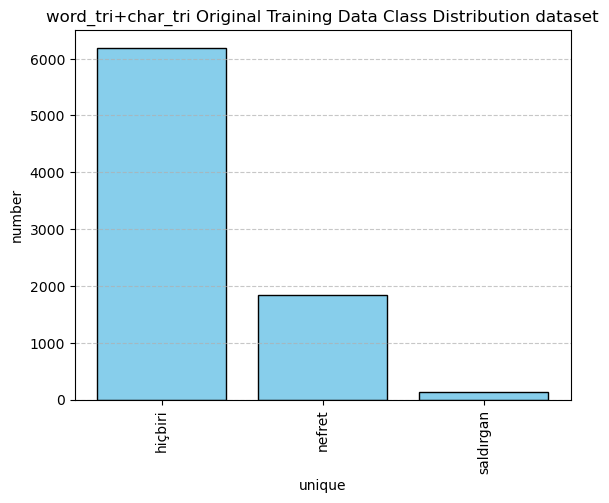

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


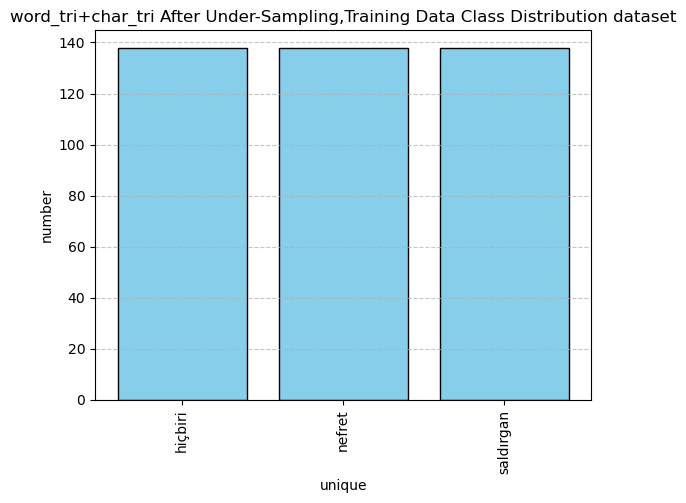

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


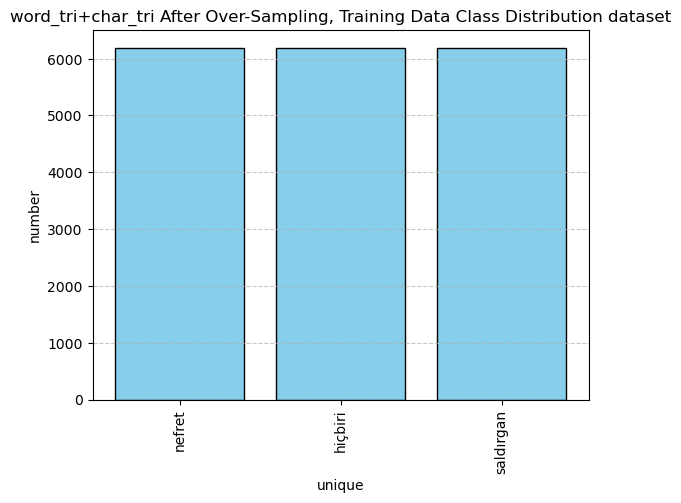

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


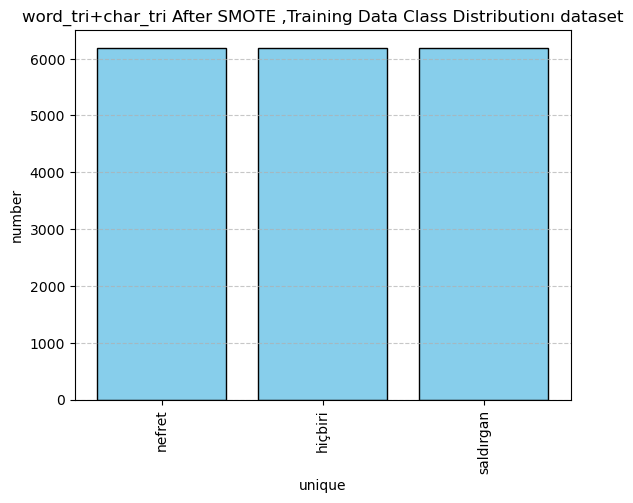


word_tri+char_tri:

XGBoost,Under-Sampling,word_tri+char_tri:
accuracy: 0.4102689486552567
precision: 0.6326681653246251
recall: 0.4102689486552567
f1: 0.4280388951475887
Training Accuracy: 0.3695652173913044
Validation Accuracy: 0.4102689486552567

word_tri+char_tri:

CatBoostC,Under-Sampling,word_tri+char_tri:
accuracy: 0.5545232273838631
precision: 0.6947910642326474
recall: 0.5545232273838631
f1: 0.605369518144594
Training Accuracy: 0.4879227053140096
Validation Accuracy: 0.5545232273838631

word_tri+char_tri:

MLPC-sgd,Under-Sampling,word_tri+char_tri:
accuracy: 0.5300733496332518
precision: 0.7261427094807171
recall: 0.5300733496332518
f1: 0.6065311265402523
Training Accuracy: 0.4806763285024154
Validation Accuracy: 0.5300733496332518

word_tri+char_tri:

ExtraTreesClassifier,Under-Sampling,word_tri+char_tri:
accuracy: 0.5491442542787286
precision: 0.747378496008514
recall: 0.5491442542787286
f1: 0.6112365787596845
Training Accuracy: 0.5386473429951691
Validation Accuracy: 0.549

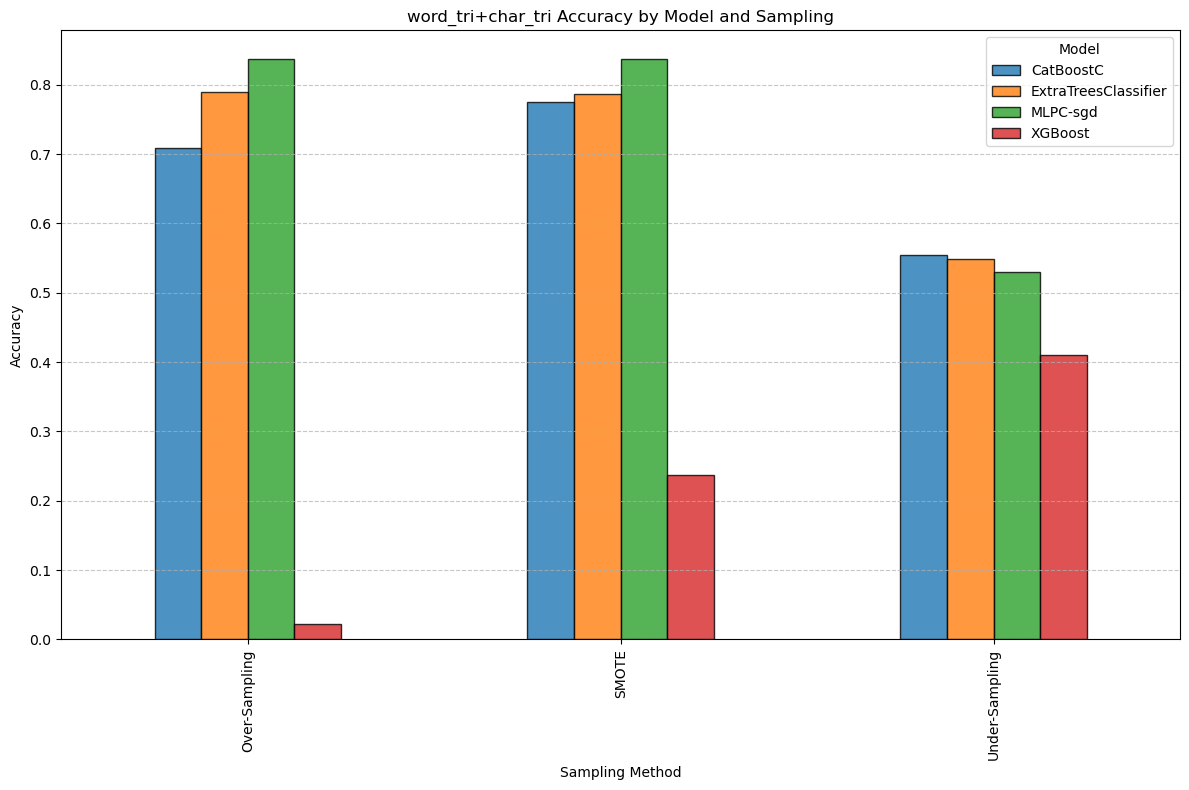

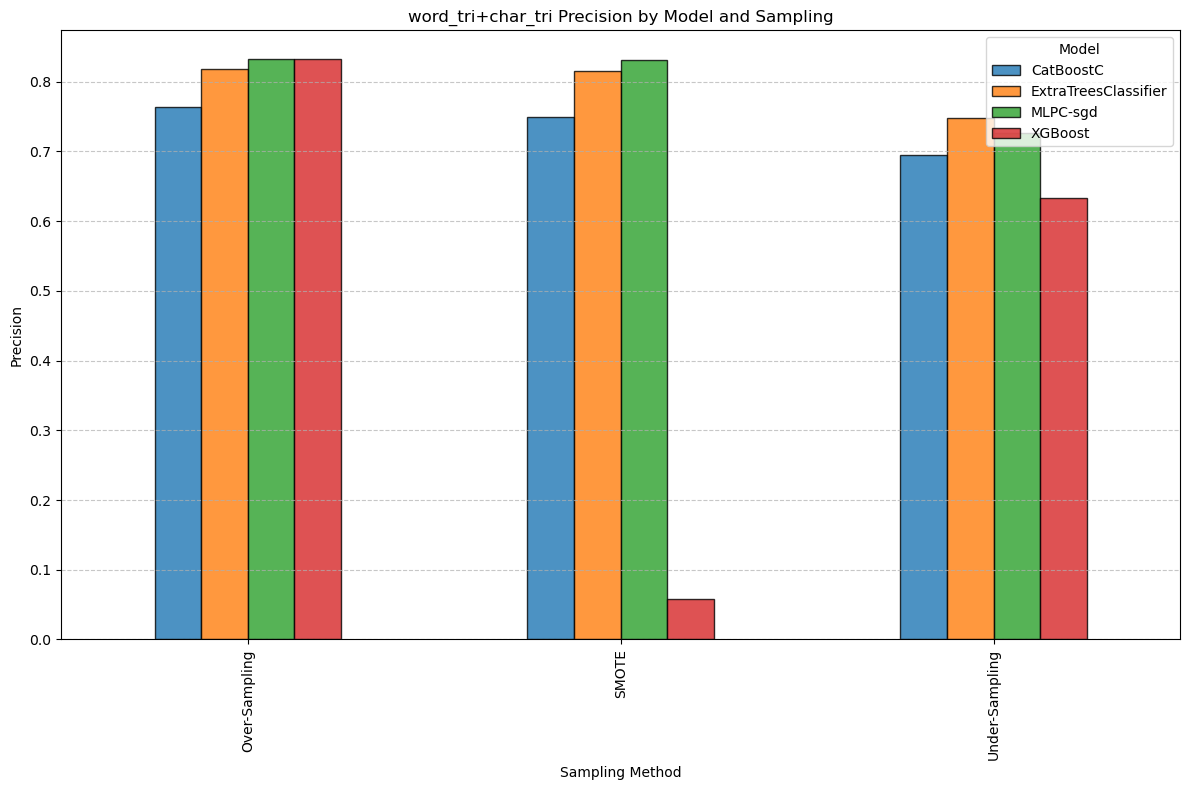

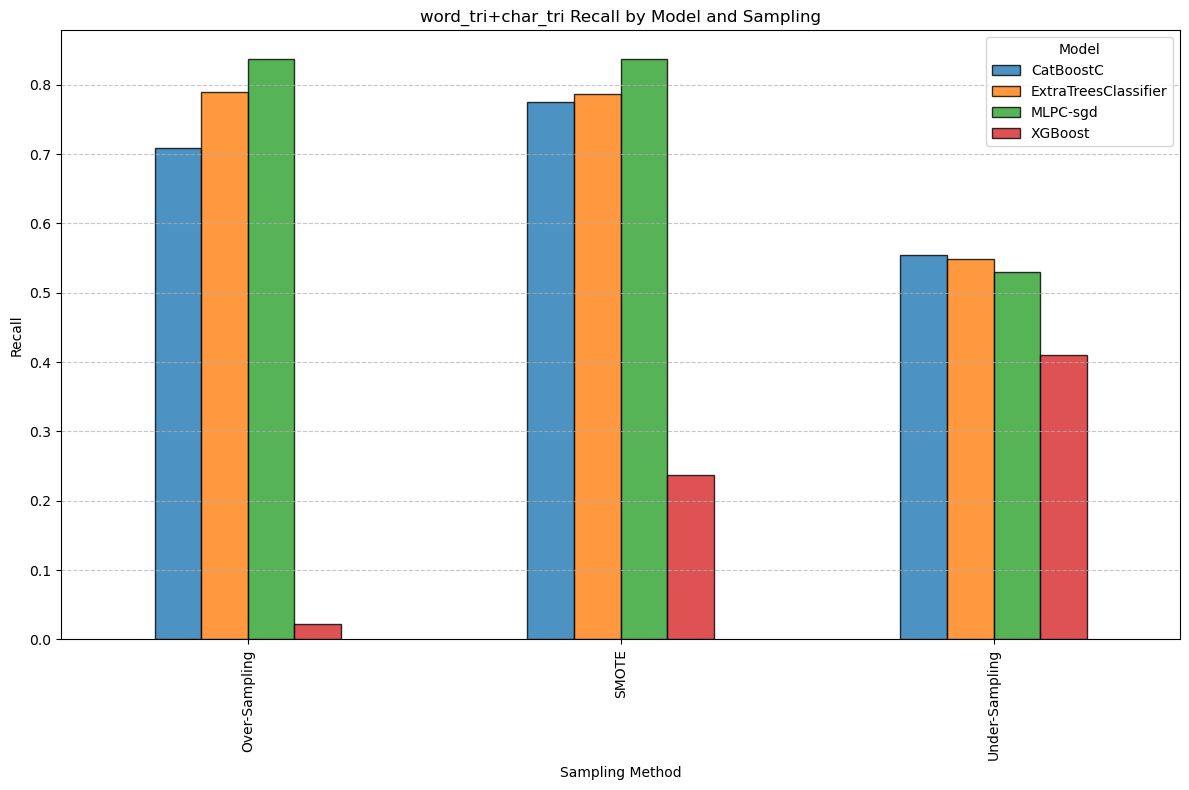

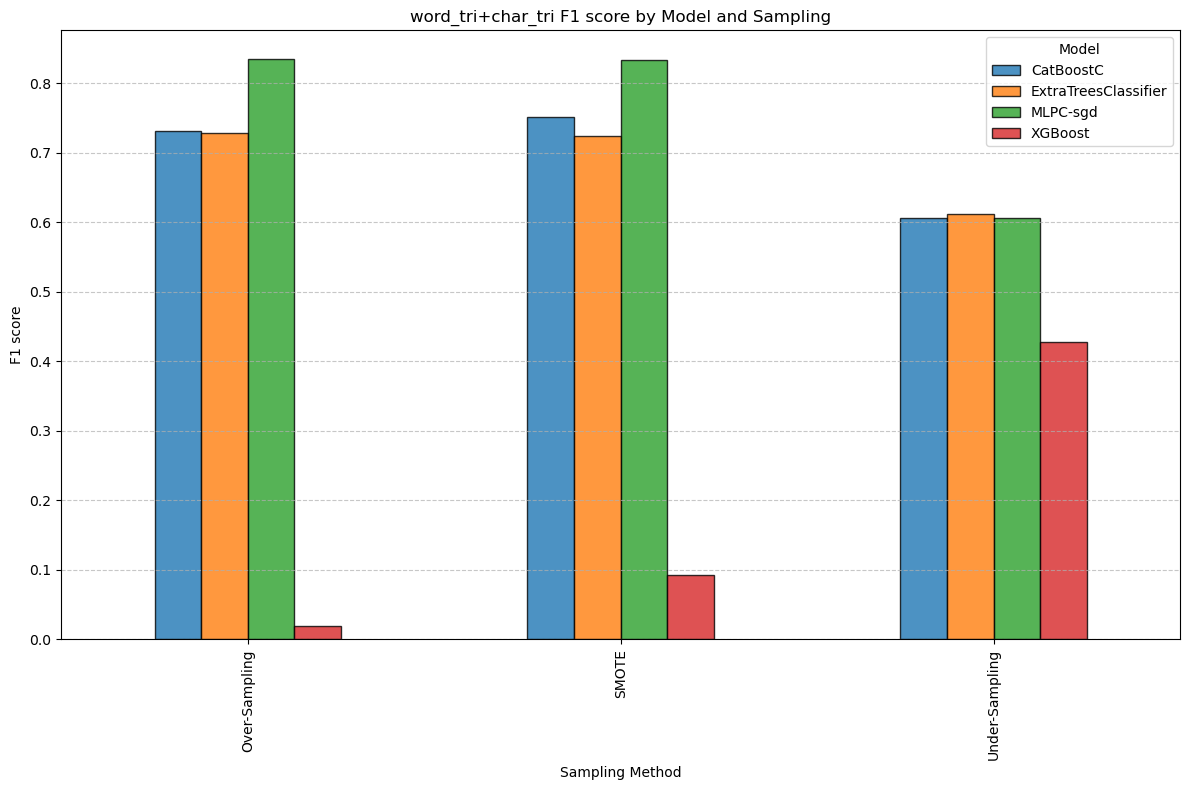

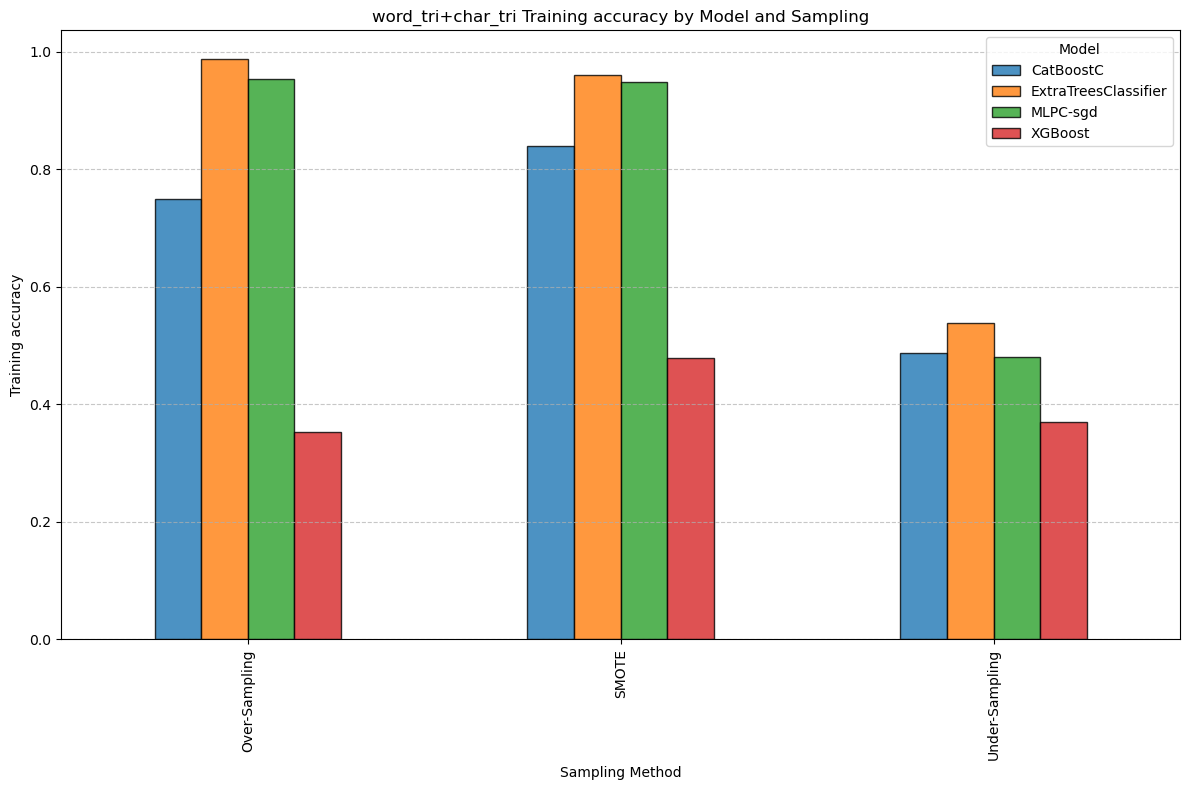

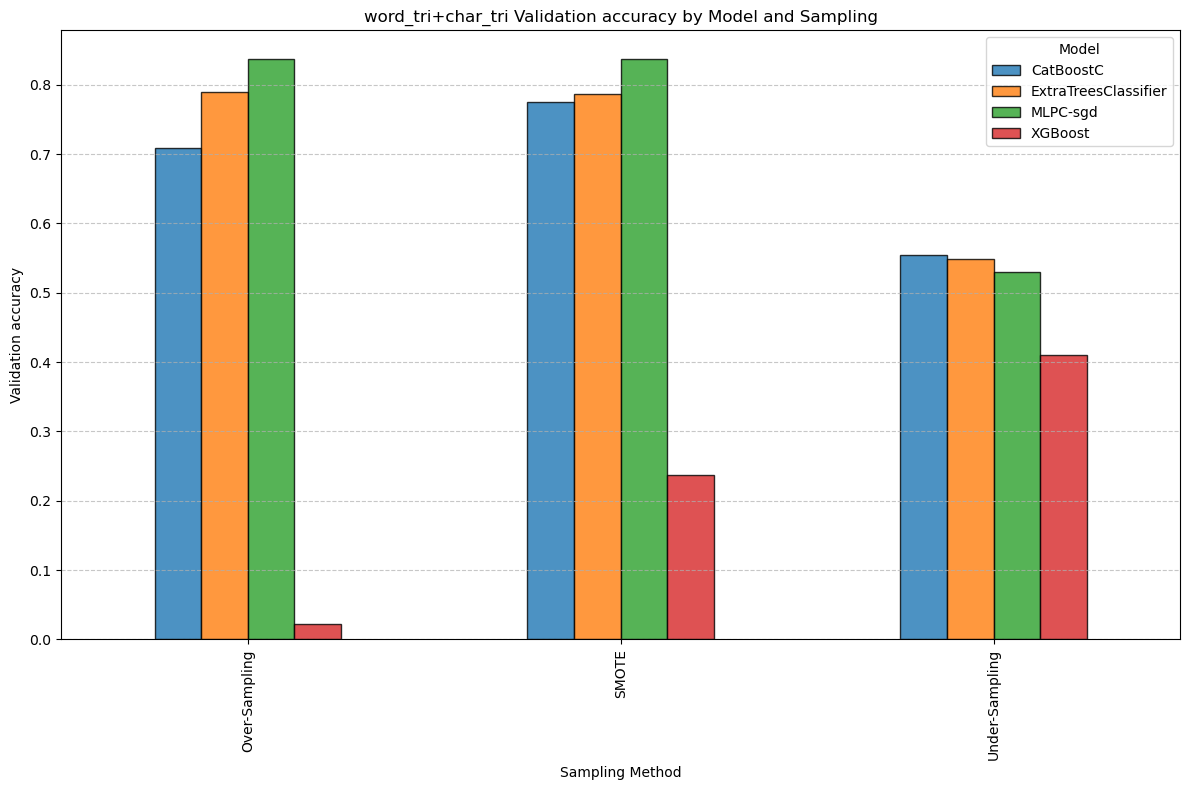

In [121]:
feature_unionAndmodel_training("word_tri+char_tri",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["word_tri+char_tri"] = results_df

# char unigram + char trigram-------------------------------------------

In [123]:

feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),
    
    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
    
])



etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


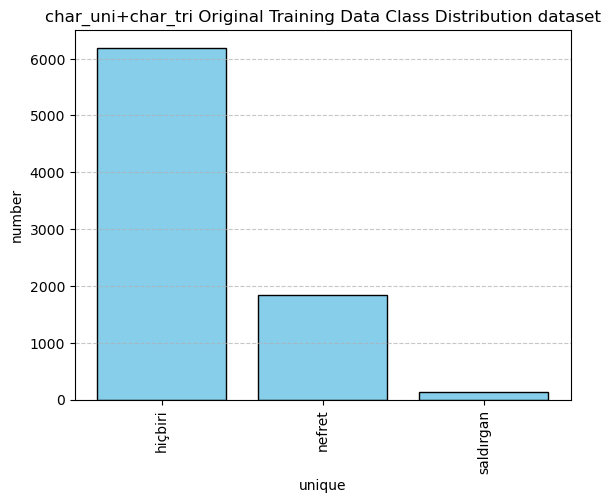

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


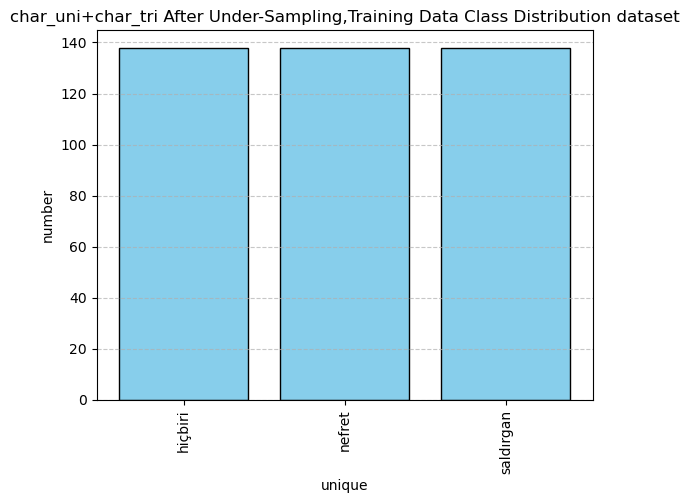

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


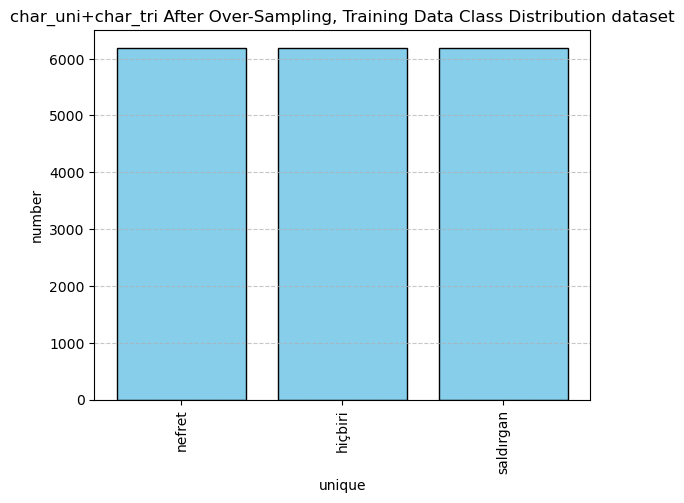

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


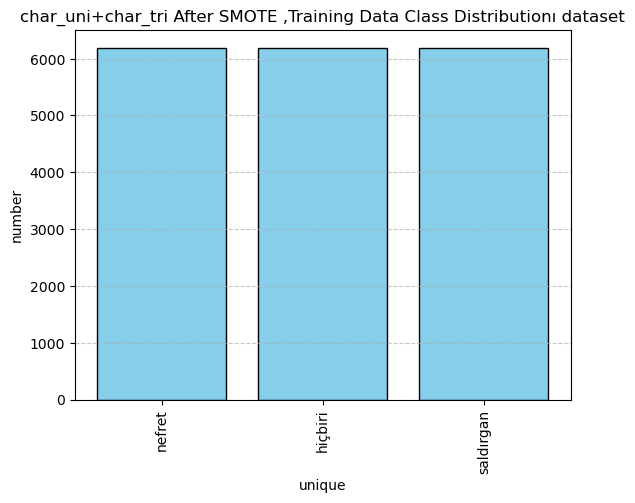


char_uni+char_tri:

XGBoost,Under-Sampling,char_uni+char_tri:
accuracy: 0.6400977995110024
precision: 0.5871215502758061
recall: 0.6400977995110024
f1: 0.610624168789445
Training Accuracy: 0.37198067632850246
Validation Accuracy: 0.6400977995110024

char_uni+char_tri:

CatBoostC,Under-Sampling,char_uni+char_tri:
accuracy: 0.5202933985330074
precision: 0.6954071506598201
recall: 0.5202933985330074
f1: 0.5789420190665412
Training Accuracy: 0.4879227053140096
Validation Accuracy: 0.5202933985330074

char_uni+char_tri:

MLPC-sgd,Under-Sampling,char_uni+char_tri:
accuracy: 0.4356968215158924
precision: 0.6739252814384025
recall: 0.4356968215158924
f1: 0.5167196176640665
Training Accuracy: 0.4057971014492754
Validation Accuracy: 0.4356968215158924

char_uni+char_tri:

ExtraTreesClassifier,Under-Sampling,char_uni+char_tri:
accuracy: 0.5677261613691932
precision: 0.7466939546285011
recall: 0.5677261613691932
f1: 0.6234122817232957
Training Accuracy: 0.5652173913043478
Validation Accuracy: 0.5

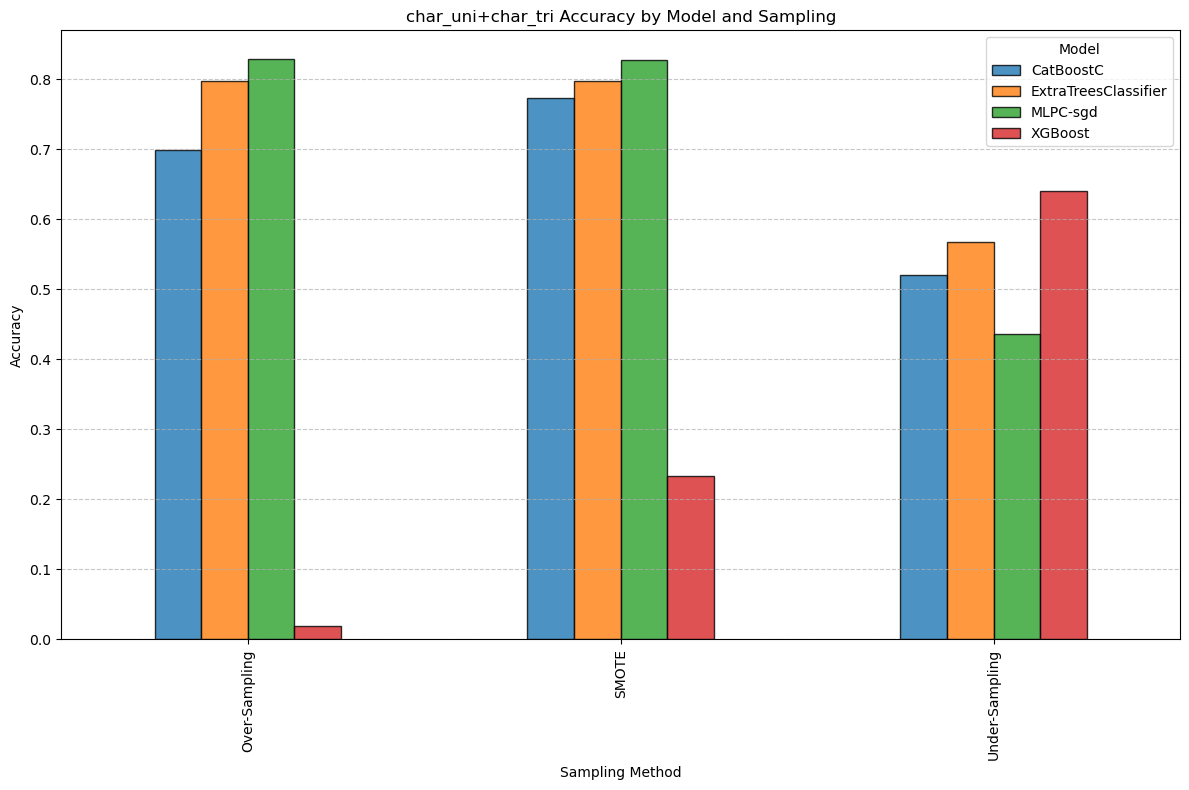

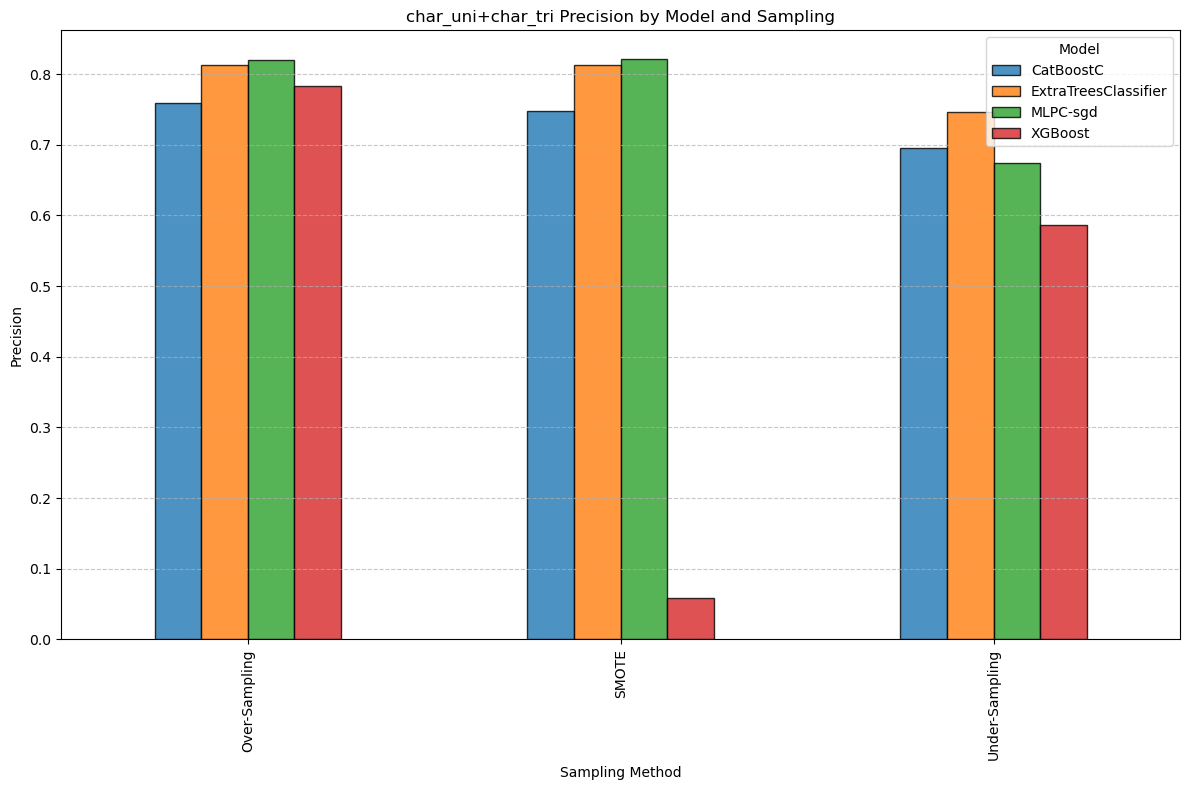

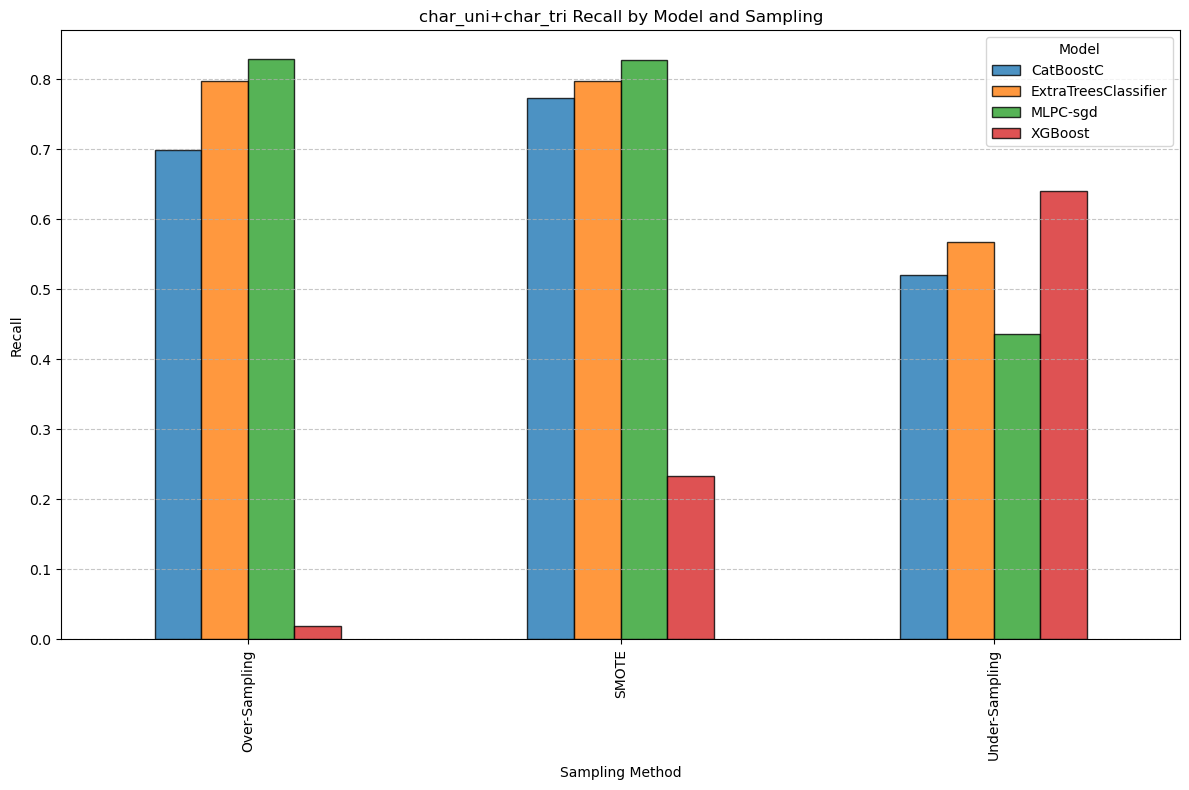

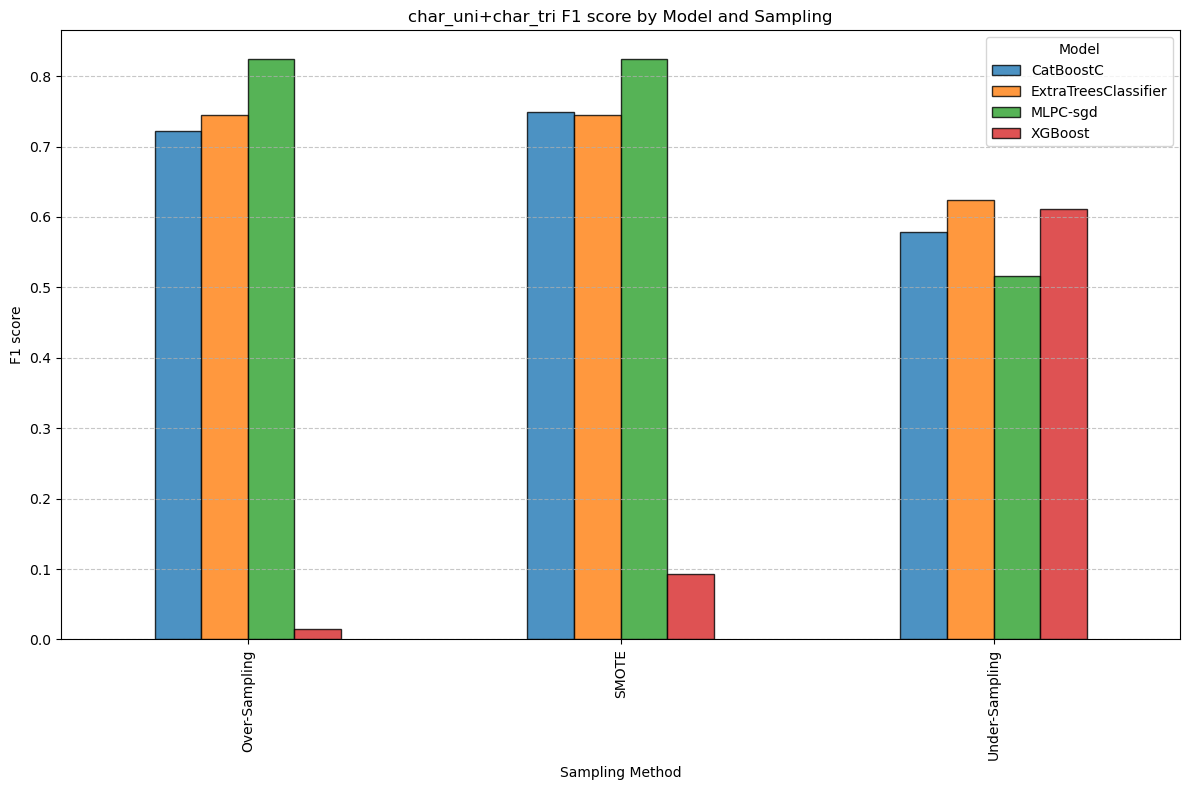

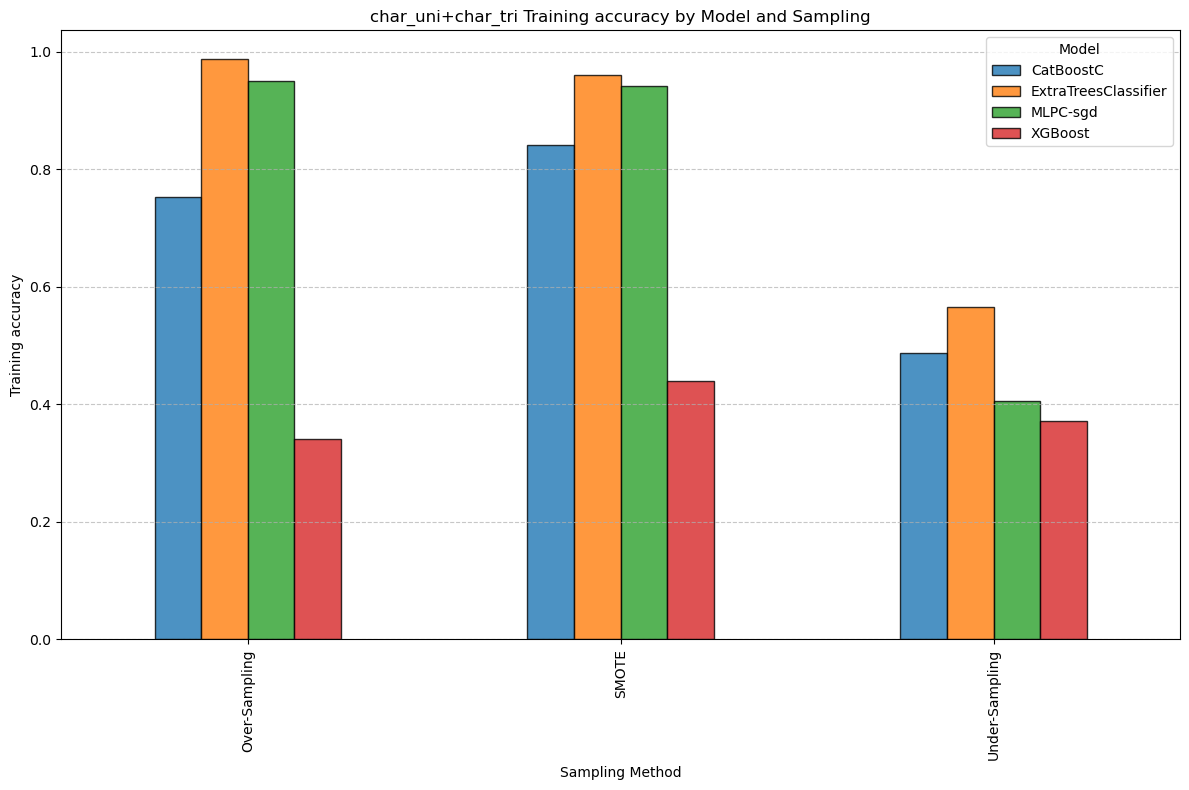

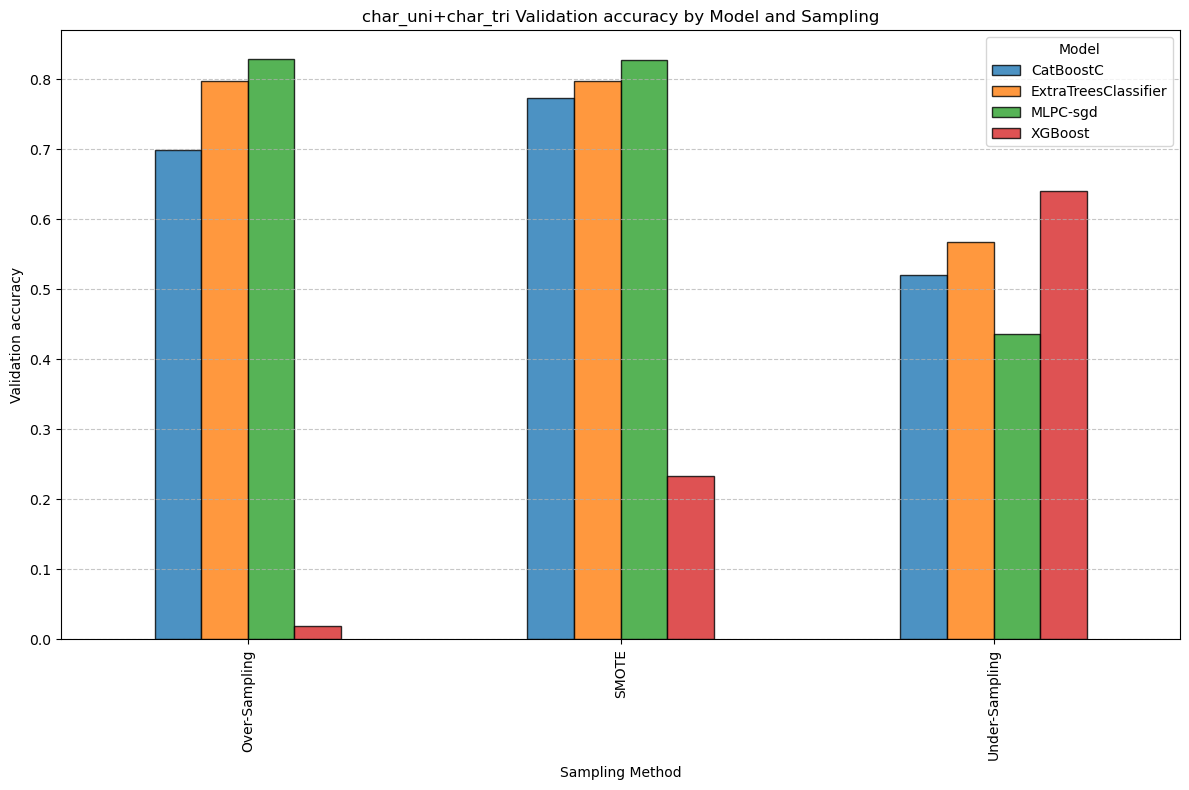

In [124]:
feature_unionAndmodel_training("char_uni+char_tri",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["char_uni+char_tri"] = results_df

# word unigram + word bigram + char trigram -------------------------------------------

In [126]:

feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),
    
    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf),
    
    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
    
])


etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


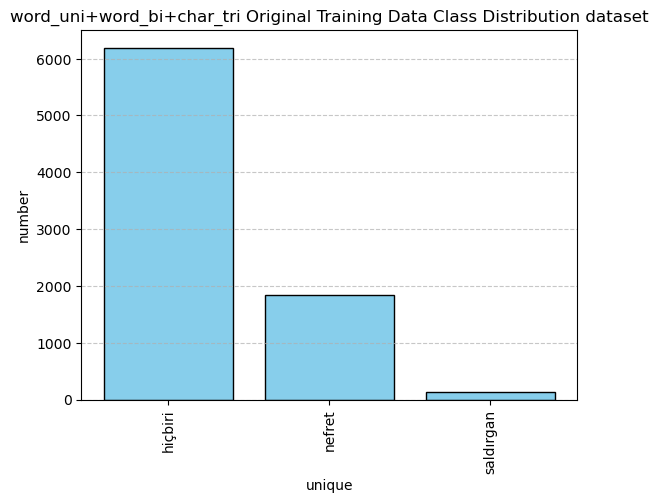

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


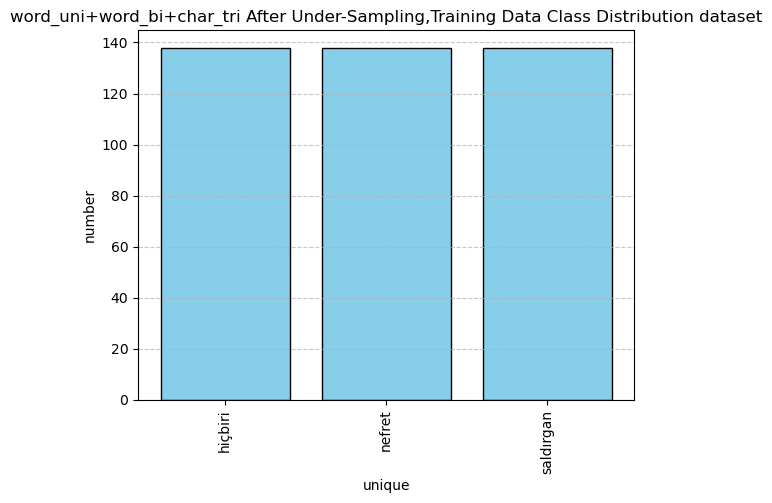

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


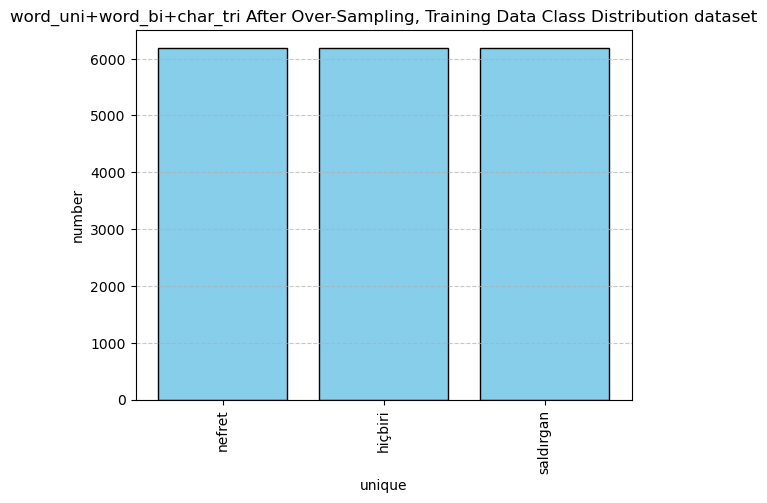

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


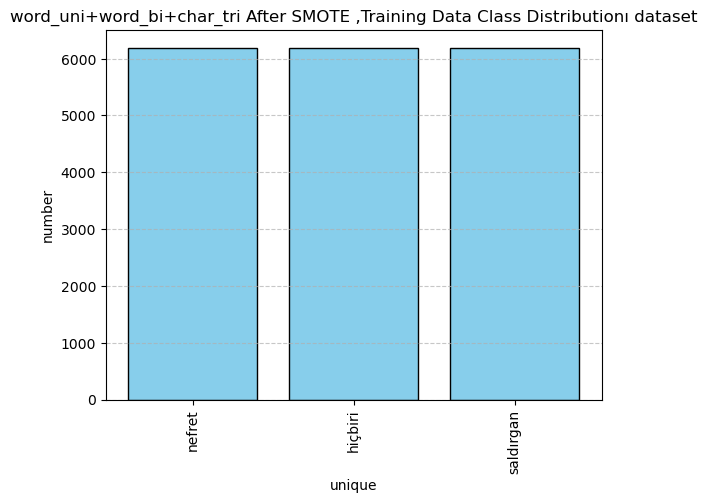


word_uni+word_bi+char_tri:

XGBoost,Under-Sampling,word_uni+word_bi+char_tri:
accuracy: 0.2396088019559902
precision: 0.6010213048009339
recall: 0.2396088019559902
f1: 0.10066342121438328
Training Accuracy: 0.357487922705314
Validation Accuracy: 0.2396088019559902

word_uni+word_bi+char_tri:

CatBoostC,Under-Sampling,word_uni+word_bi+char_tri:
accuracy: 0.5246943765281173
precision: 0.697460324720474
recall: 0.5246943765281173
f1: 0.5850971267318494
Training Accuracy: 0.4613526570048309
Validation Accuracy: 0.5246943765281173

word_uni+word_bi+char_tri:

MLPC-sgd,Under-Sampling,word_uni+word_bi+char_tri:
accuracy: 0.4924205378973105
precision: 0.6964274470421332
recall: 0.4924205378973105
f1: 0.5582339864481477
Training Accuracy: 0.5048309178743962
Validation Accuracy: 0.4924205378973105

word_uni+word_bi+char_tri:

ExtraTreesClassifier,Under-Sampling,word_uni+word_bi+char_tri:
accuracy: 0.5691931540342299
precision: 0.756086457759344
recall: 0.5691931540342299
f1: 0.6261420613838502


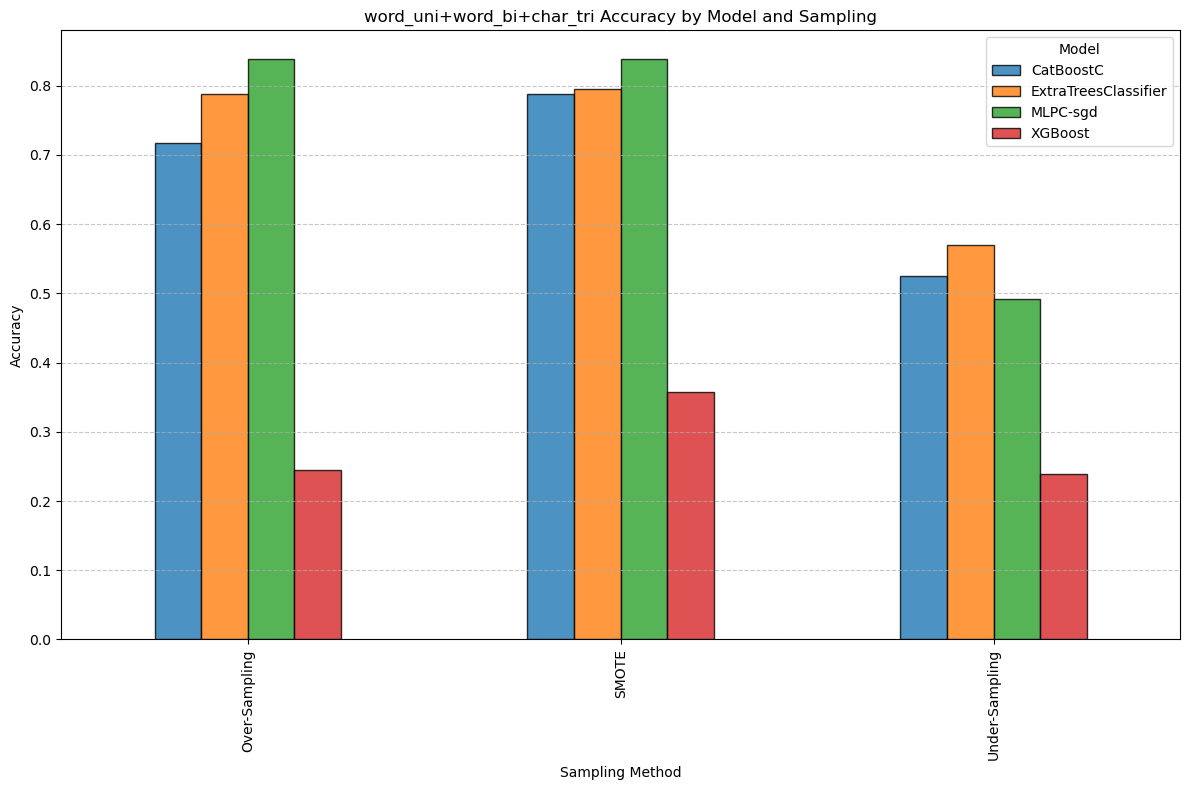

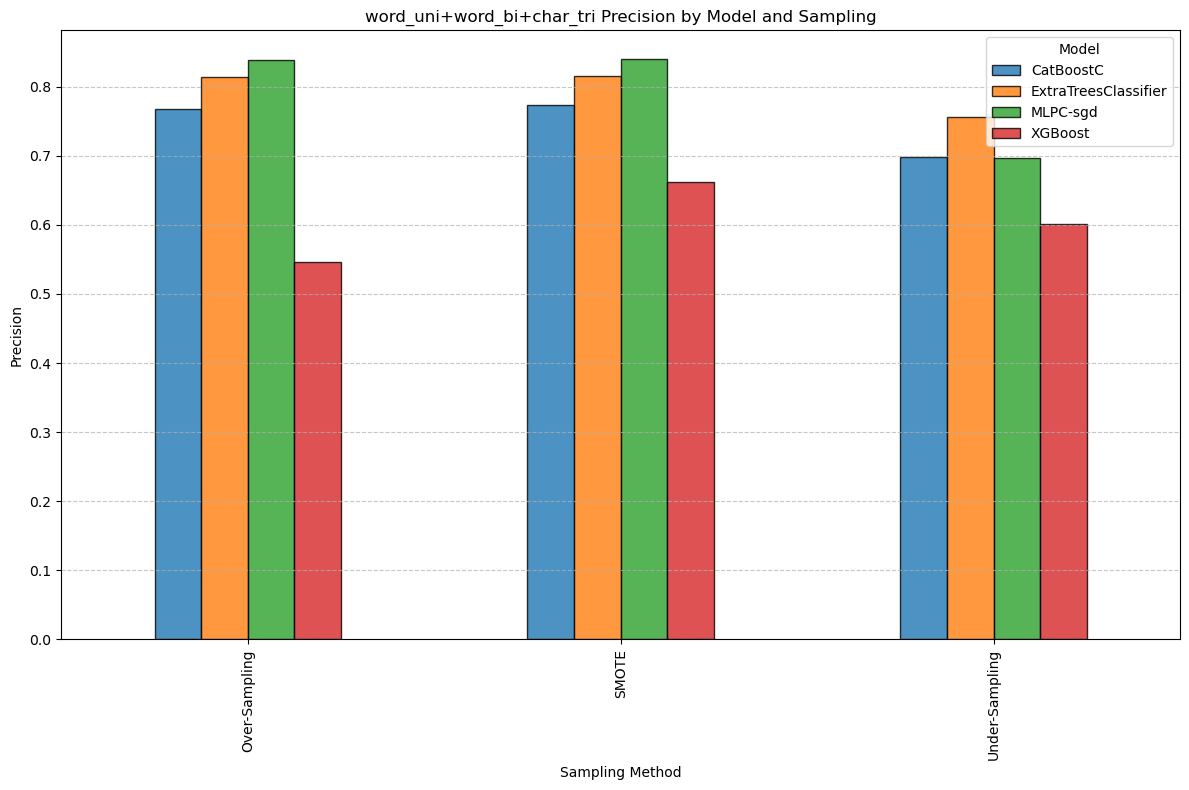

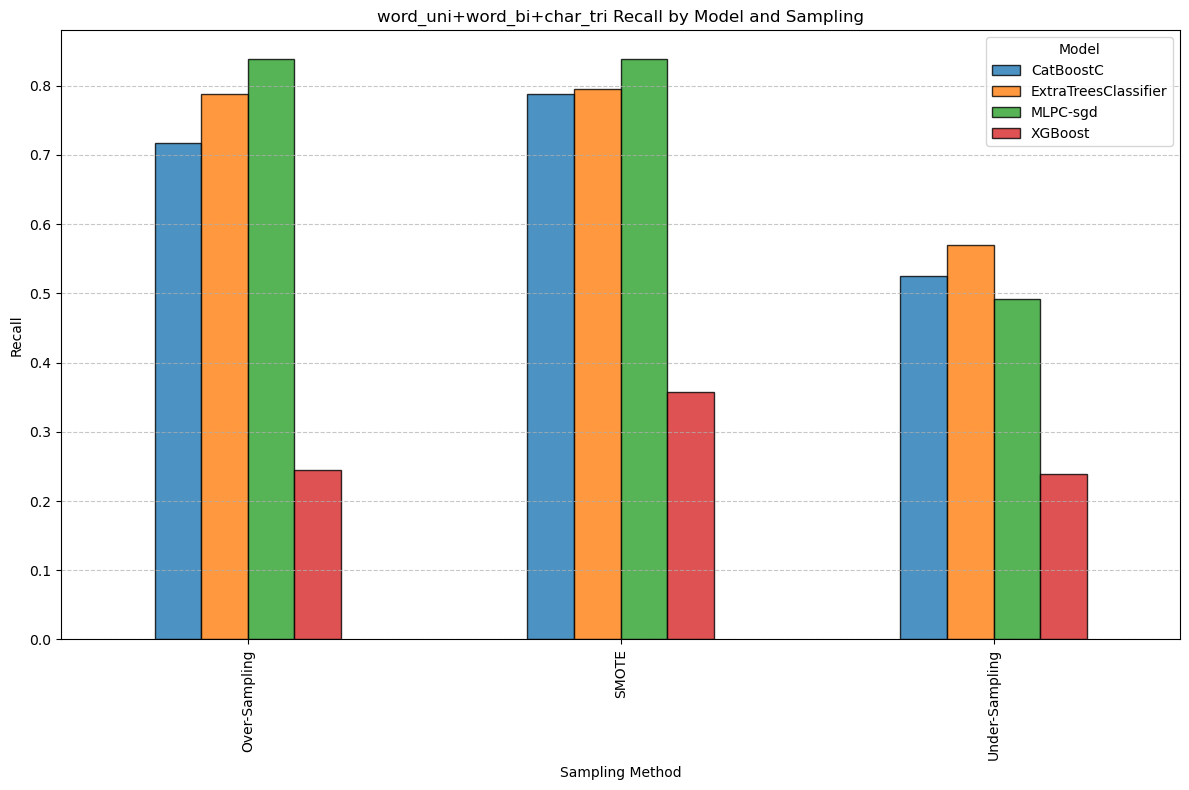

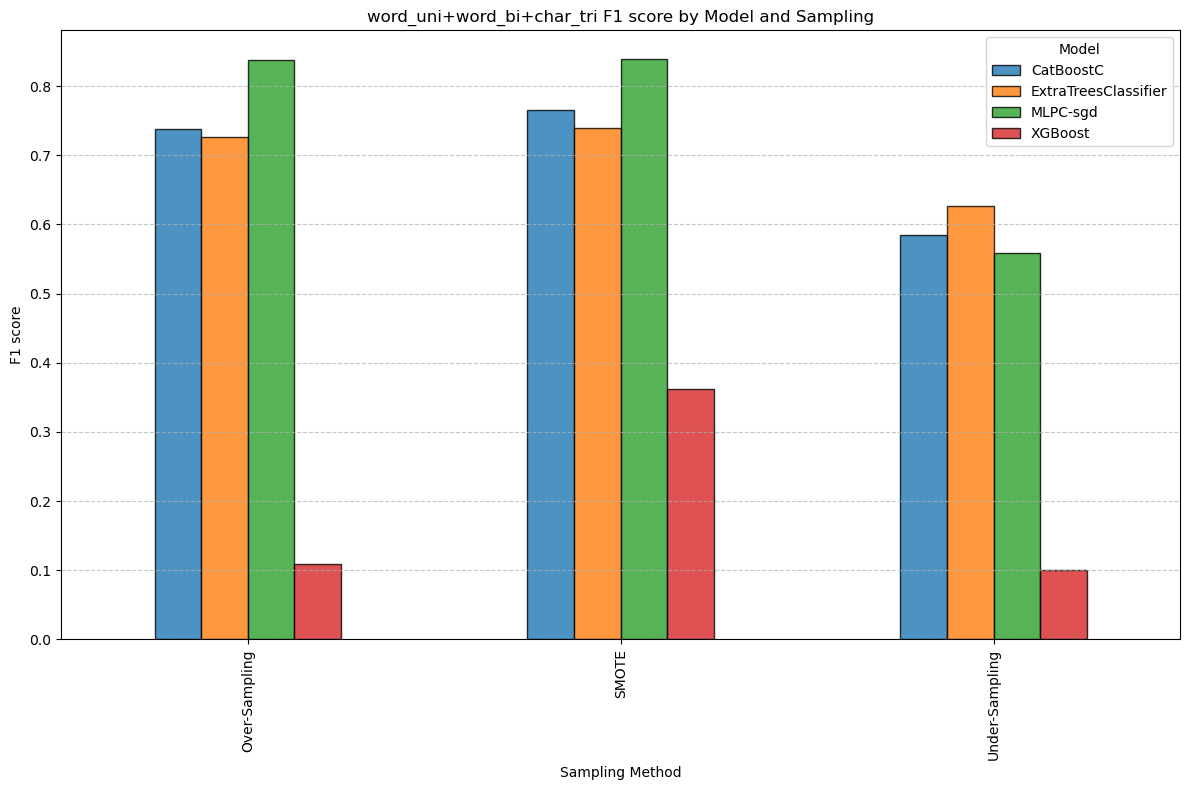

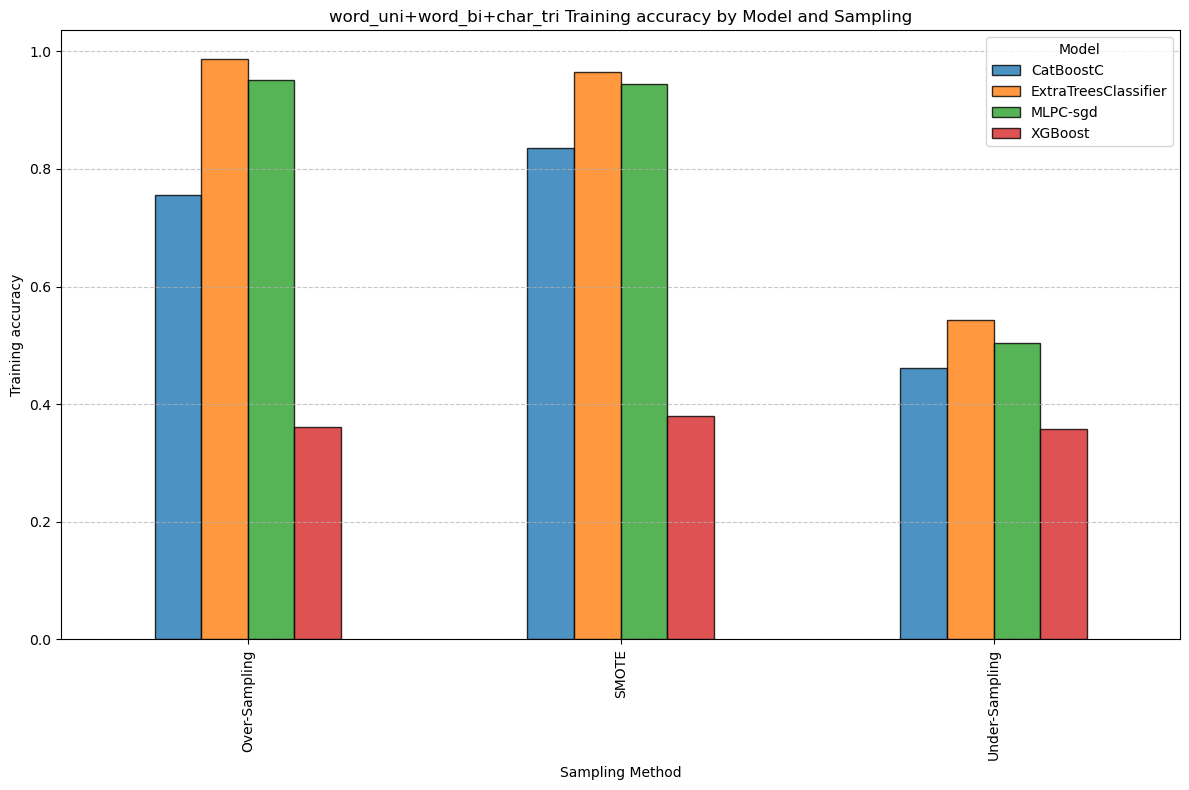

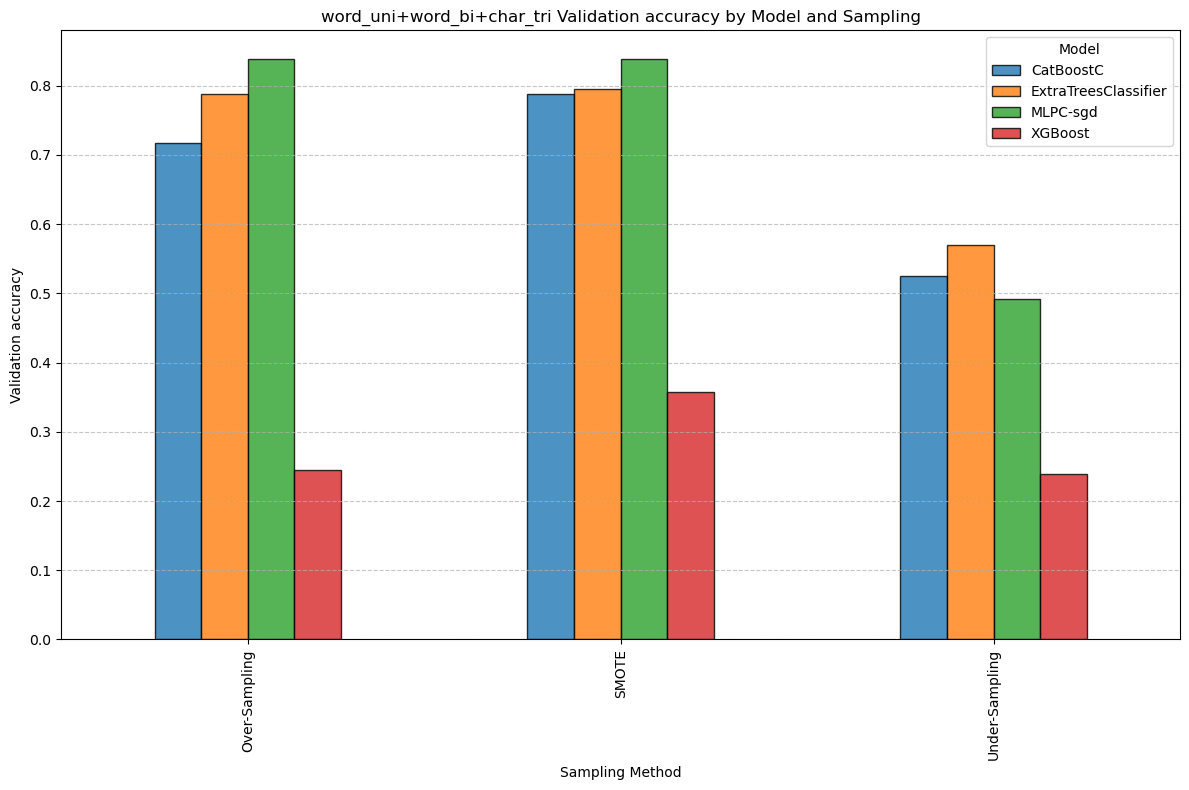

In [127]:
feature_unionAndmodel_training("word_uni+word_bi+char_tri",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["word_uni+word_bi+char_tri"] = results_df

# word unigram + word bigram + char bigram + char trigram -------------------------------------------

In [129]:

feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),
    
    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf),
        
    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf),
    
    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
    
])



etiket
0    6195
1    1846
2     138
Name: count, dtype: int64


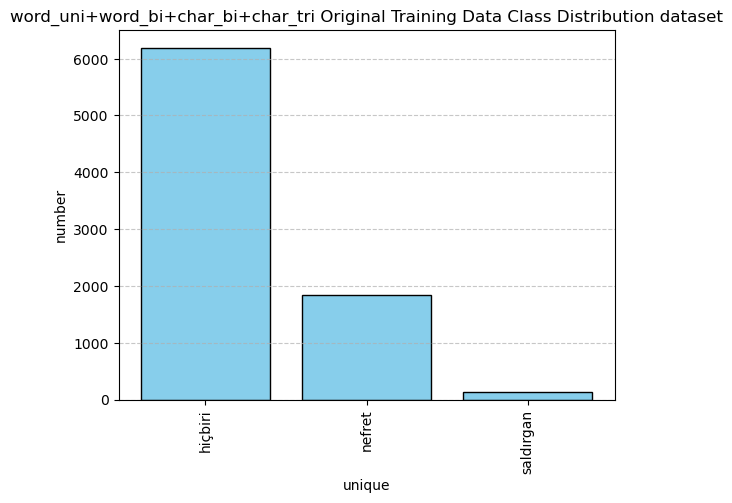

Original Training Data Class Distributionı: Counter({0: 6195, 1: 1846, 2: 138})
etiket
0    138
1    138
2    138
Name: count, dtype: int64


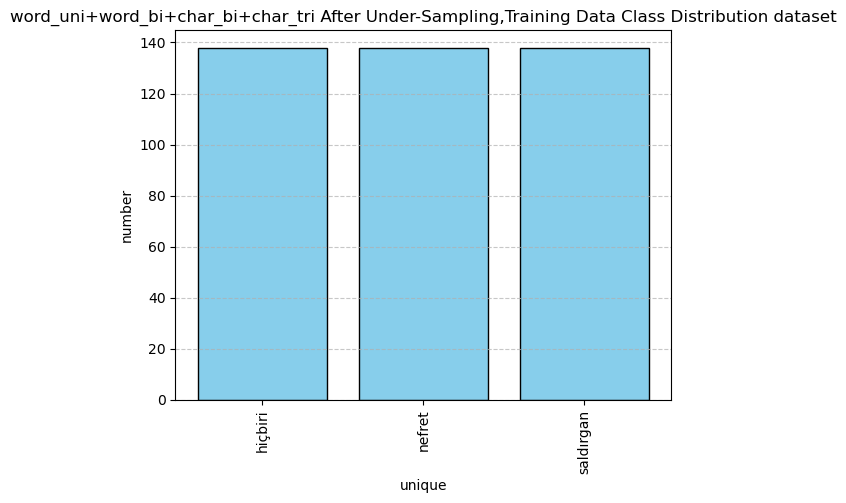

After Under-Sampling,Training Data Class Distribution: Counter({0: 138, 1: 138, 2: 138})
After Over-Sampling, Training Data Class Distribution: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


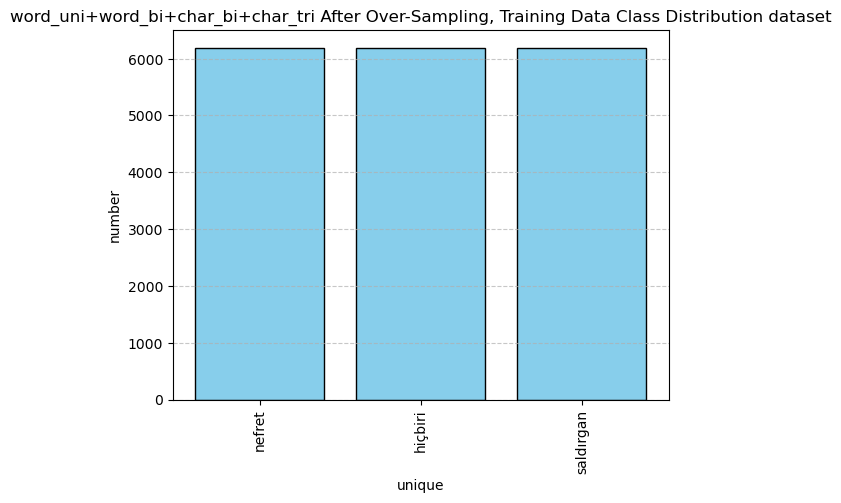

After SMOTE ,Training Data Class Distributionı: Counter({1: 6195, 0: 6195, 2: 6195})
etiket
1    6195
0    6195
2    6195
Name: count, dtype: int64


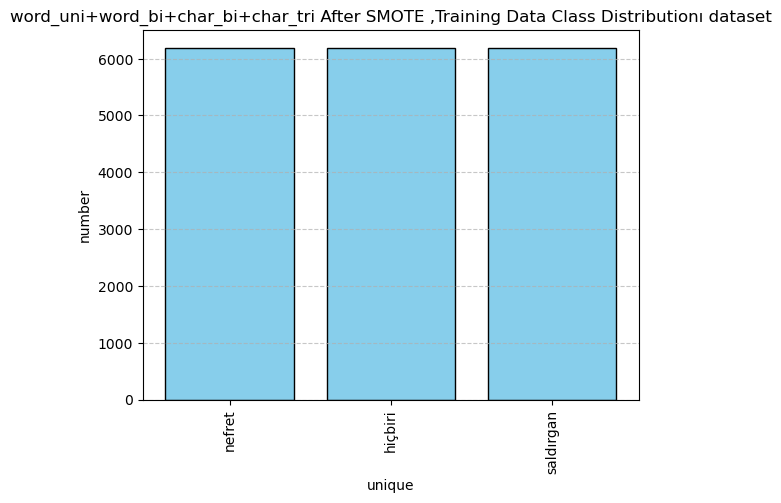


word_uni+word_bi+char_bi+char_tri:

XGBoost,Under-Sampling,word_uni+word_bi+char_bi+char_tri:
accuracy: 0.013691931540342298
precision: 0.0001874689893054202
recall: 0.013691931540342298
f1: 0.0003698736933232844
Training Accuracy: 0.32850241545893716
Validation Accuracy: 0.013691931540342298

word_uni+word_bi+char_bi+char_tri:

CatBoostC,Under-Sampling,word_uni+word_bi+char_bi+char_tri:
accuracy: 0.49779951100244496
precision: 0.69280455043867
recall: 0.49779951100244496
f1: 0.5567203737246547
Training Accuracy: 0.43719806763285024
Validation Accuracy: 0.49779951100244496

word_uni+word_bi+char_bi+char_tri:

MLPC-sgd,Under-Sampling,word_uni+word_bi+char_bi+char_tri:
accuracy: 0.4963325183374083
precision: 0.6773985151234119
recall: 0.4963325183374083
f1: 0.5658100095215349
Training Accuracy: 0.4830917874396135
Validation Accuracy: 0.4963325183374083

word_uni+word_bi+char_bi+char_tri:

ExtraTreesClassifier,Under-Sampling,word_uni+word_bi+char_bi+char_tri:
accuracy: 0.6019559902200489

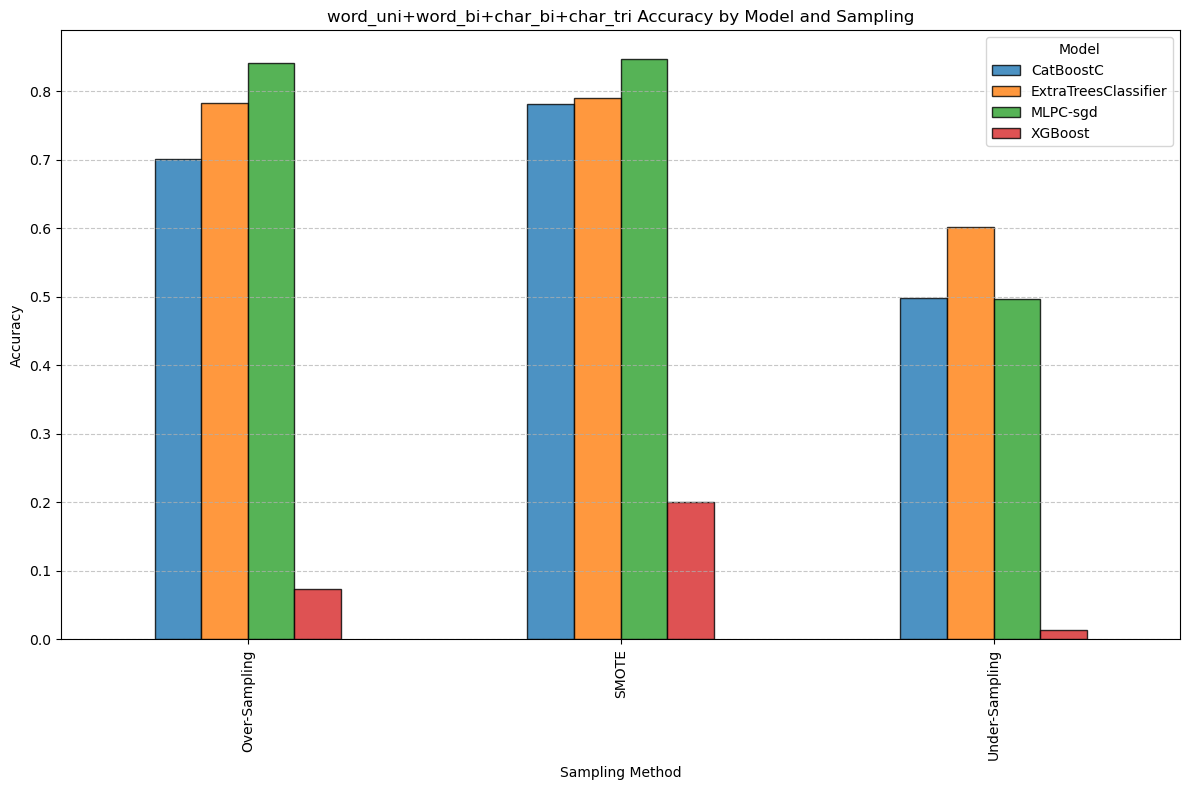

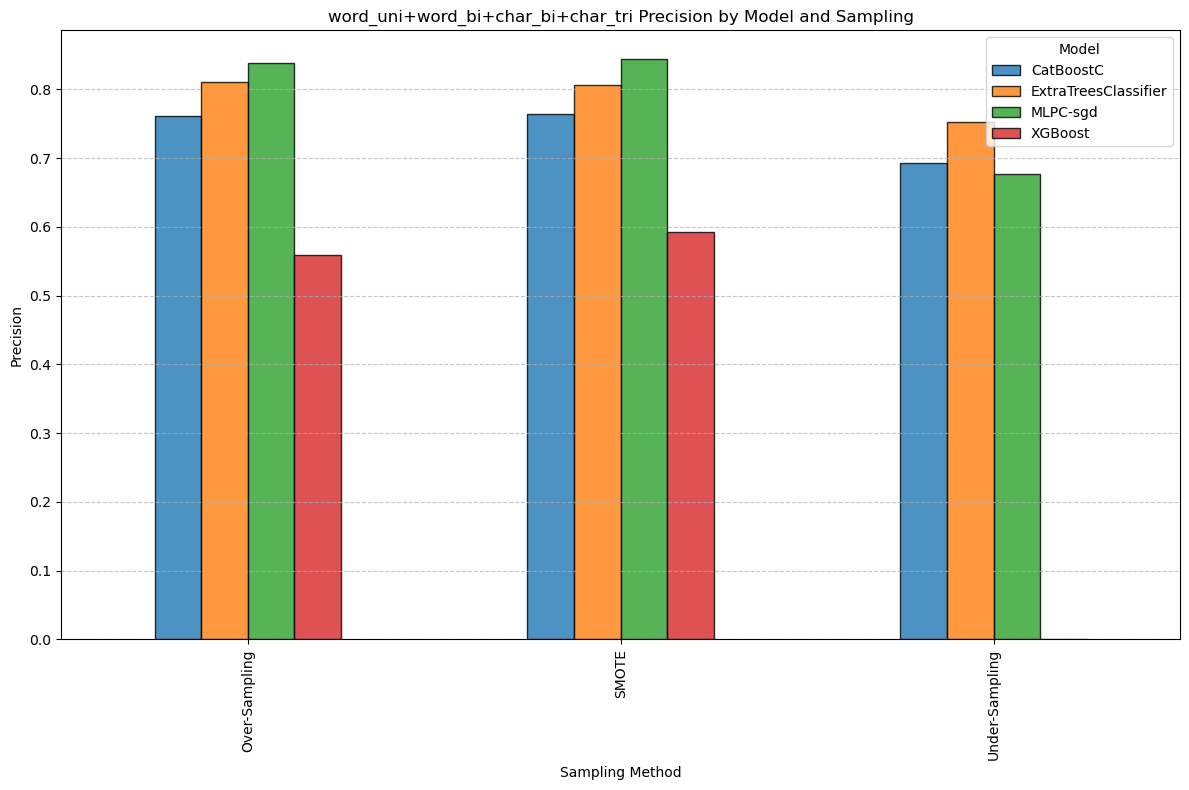

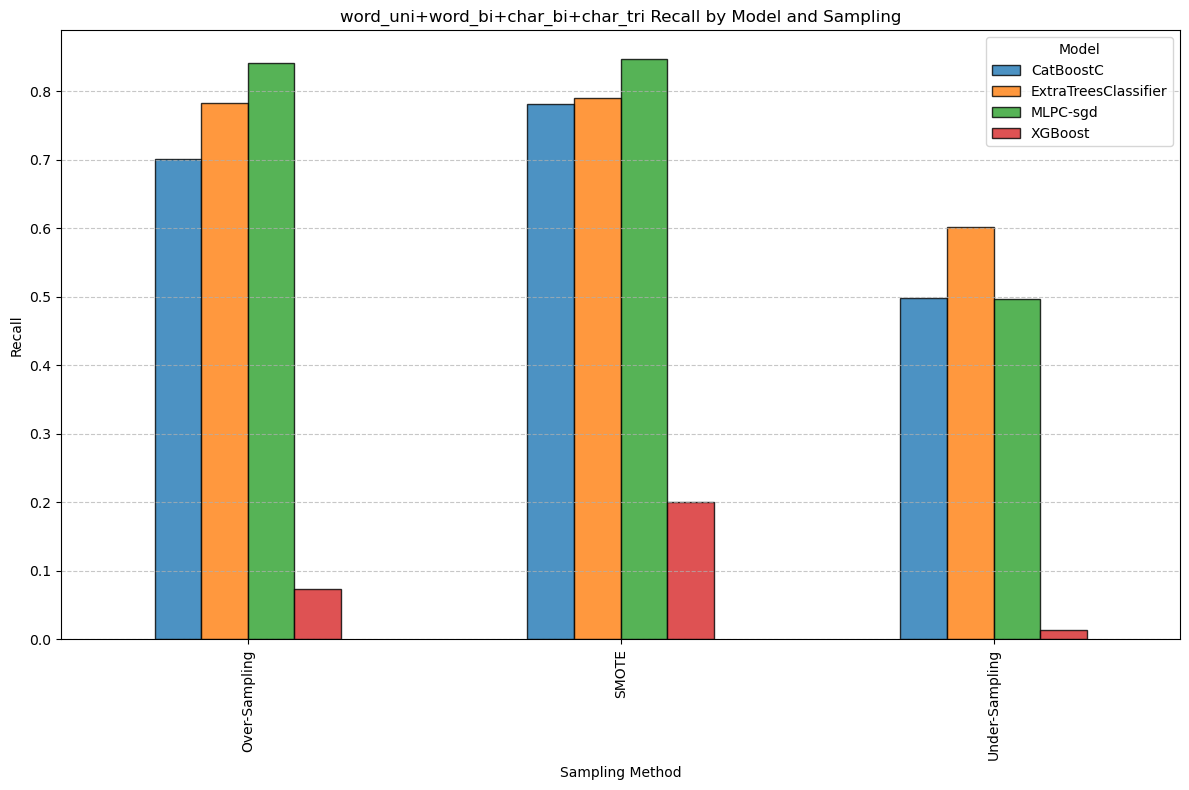

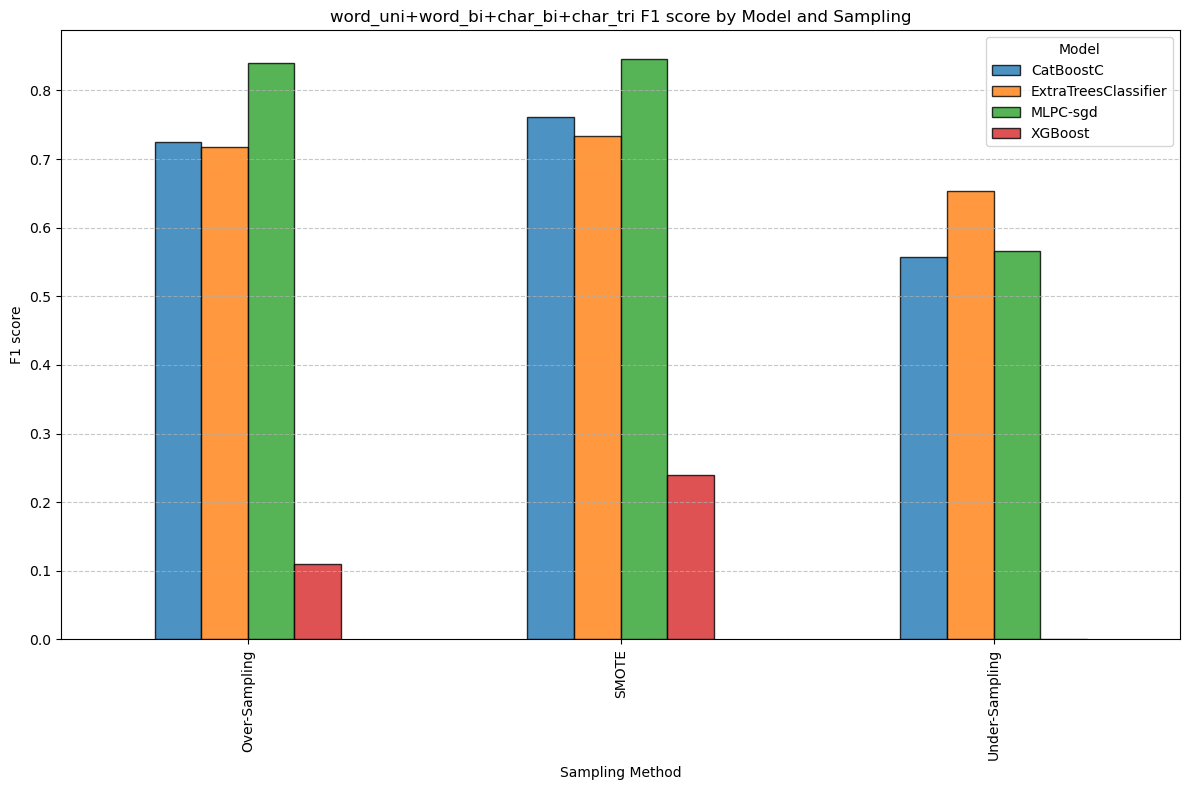

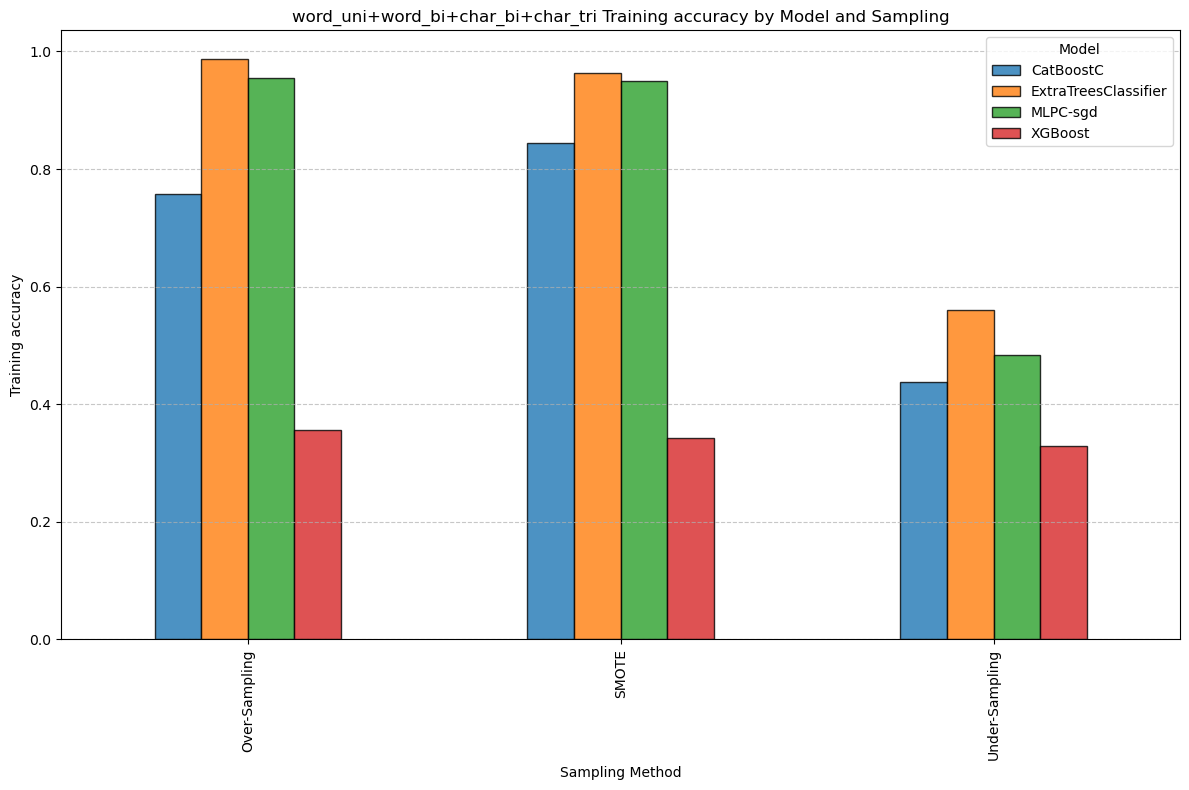

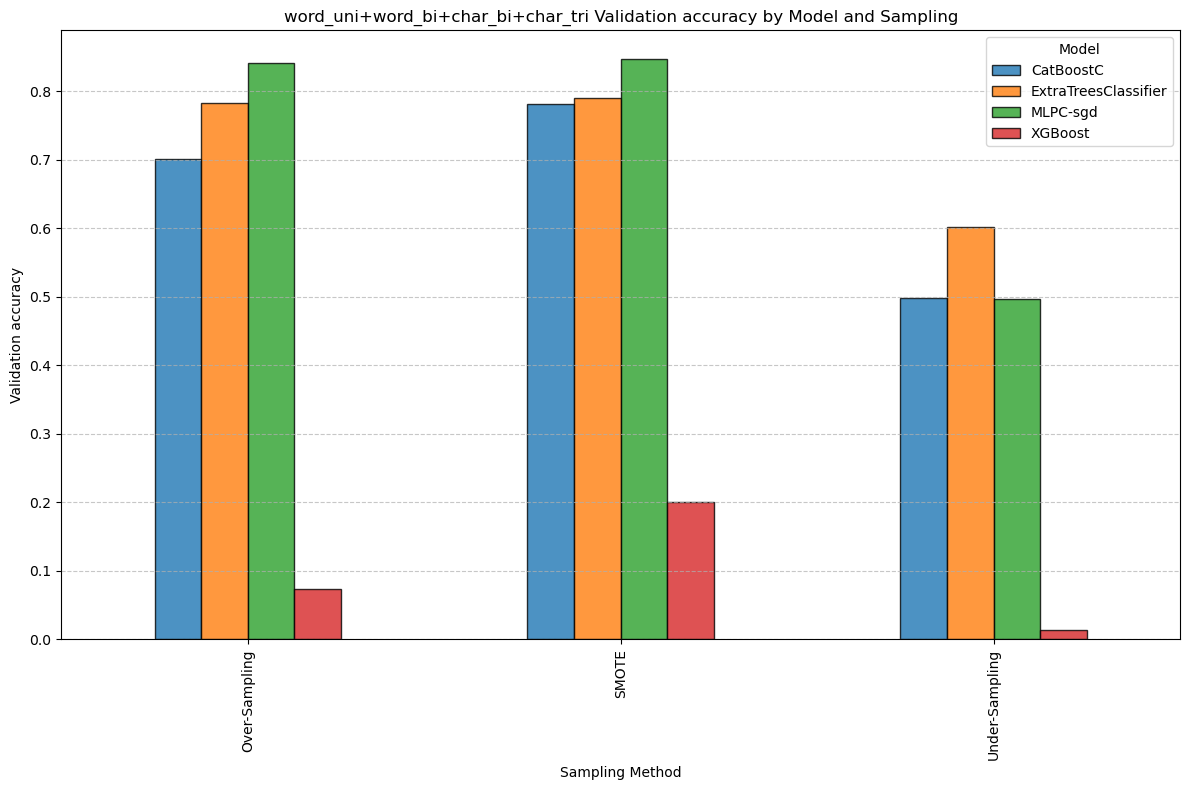

In [130]:
results_df = feature_unionAndmodel_training("word_uni+word_bi+char_bi+char_tri",feature_union,X_train, X_test, y_train, y_test,modelsAndNames,len_labels)
result_dic["word_uni+word_bi+char_bi+char_tri"] = results_df

# 😊😊conclusion😊😊

In [132]:
def dictionary_to_dataframe(result_dic):
    """
    Converts a dictionary into a DataFrame and adds the gram_name as a column.

    Parameters:
        result_dic (dict): Dictionary containing results with gram_name as keys.

    Returns:
        pd.DataFrame: Combined DataFrame with gram_name as a column.
    """
    dataframes = []

    for gram_name, metrics in result_dic.items():
        temp_df = pd.DataFrame(metrics)
        temp_df.insert(0, 'gram_name', gram_name)
        dataframes.append(temp_df)

    return pd.concat(dataframes, ignore_index=True)

def visualize_metrics(result_dic):
    """
    Visualizes the metrics from a dictionary using grouped bar charts.

    Parameters:
        result_dic (dict): Dictionary containing results with gram_name as keys.

    Returns:
        None: Displays the visualization.
    """
    # Convert dictionary to DataFrame
    final_df = dictionary_to_dataframe(result_dic)

    # Group by gram_name and calculate mean scores
    grouped_df = final_df.groupby(['gram_name', 'sampling']).mean(numeric_only=True).reset_index()

    # Metrics to plot
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'training_accuracy', 'validation_accuracy']

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(14, 8))

    # Number of gram names and metrics
    gram_sampling_labels = grouped_df[['gram_name', 'sampling']].apply(lambda x: f"{x['gram_name']}\n({x['sampling']})", axis=1)
    x = np.arange(len(gram_sampling_labels))  # The label locations
    width = 0.12  # Adjusted width for more metrics

    # Plot each metric as a separate set of bars
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, grouped_df[metric], width, label=metric.capitalize())

    # Add labels, title, and legend
    ax.set_xlabel('Gram Name and Sampling Method')
    ax.set_ylabel('Score')
    ax.set_title('Mean Scores by Gram Name, Sampling Method, and Metric')
    ax.set_xticks(x + width * len(metrics) / 2)
    ax.set_xticklabels(gram_sampling_labels, rotation=45, ha='right')
    ax.legend()

    # Add spacing between groups
    plt.tight_layout()
    plt.show()

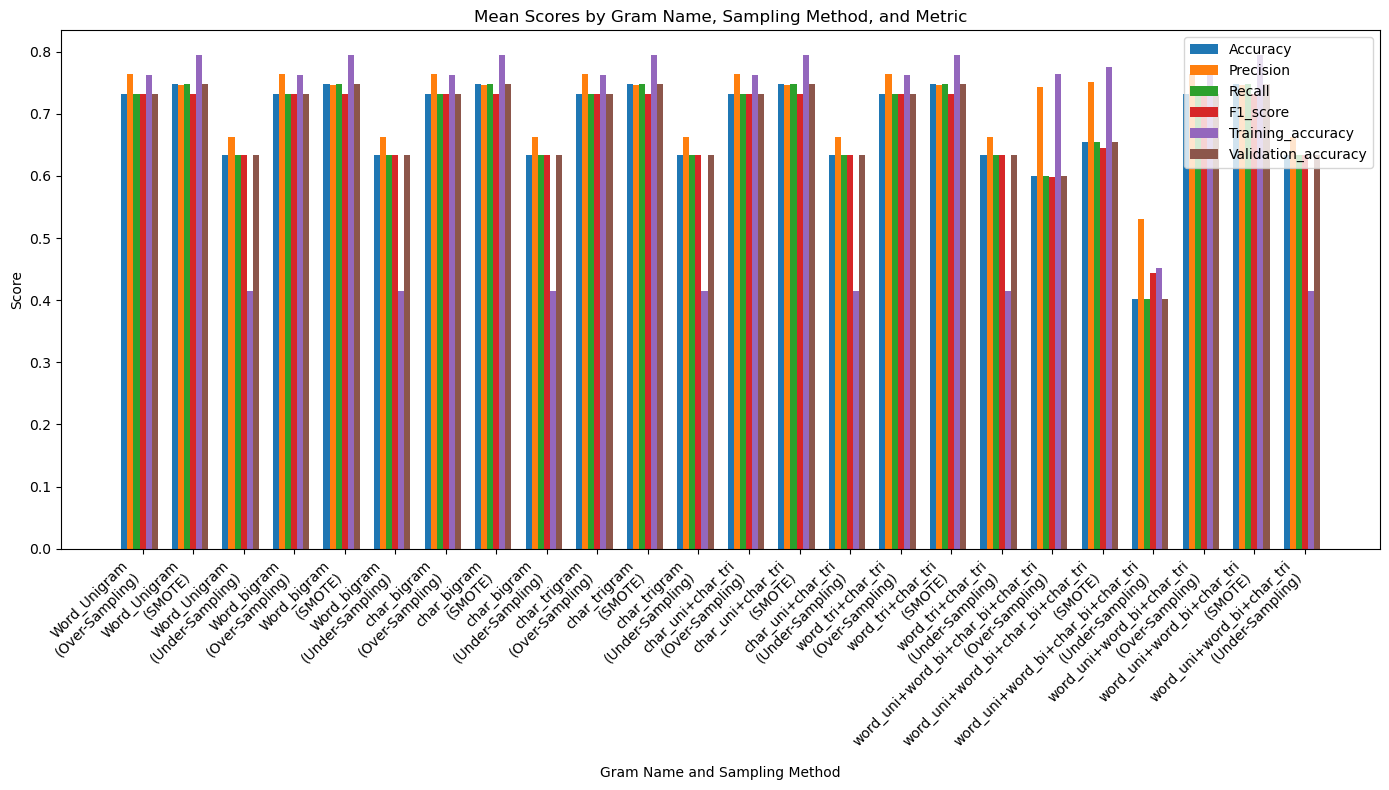

In [133]:
 visualize_metrics(result_dic)